## Loading functions

In [122]:
# import h5py loading function for big matlab file loading
import h5py

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix,  classification_report, log_loss
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from scipy.stats import norm
import scipy.io
import re
import itertools

import os
from os.path import join
import contextlib
from copy import deepcopy
import imp 
import time 
import sys

In [124]:
def load_file(file_path, key_list):
    """load parts of a v7.3 .mat file, returns as nested dictionary
    input:   file_path = full path, including filename (str)
             key_list = a list of .mat data struct (list) 
    output:  file_dict = dictionary with np arrays 
    
    e.g. load_file('/project/preproc-data-comp-cleaned-60hz.mat', ['data', 'trial'])
    will load the data.trial struct from the .mat file - because data.trial has 24 cells, 
    the output dictionary will have 24 keys and each item will have the corresponding data as
    an numpy array."""

    # open file and fetch information # file = h5py.File(join(input_dir, fn), 'r')
    with h5py.File(file_path, 'r') as file:

        # get partial file
        file_ref = _navigate_nested_dict(file, key_list)
        print(f'Data struct:  {".".join(key_list)} \t\t [shape={file_ref.shape}]')

        # loop over cells to construct ndarray
        file_ref_shape = _simplify_shape(file_ref.shape)
        for_list = _recursive_shape_iterator(file_ref_shape)

        # predefine dictionary for saving file information
        file_dict = {}

        # loop over list of nested struct and construct file
        for cell in for_list:

            # load h5py data into array based on file refference
            file_dict[cell] = np.array(file[file_ref[cell][0]])     # construct np.array
    
    print(f'Data saved in dictionary!')
    return(file_dict)


def load_labels(file_path, key_list=['data', 'label']):
    """load parts of a v7.3 .mat file, returns as nested dictionary
    input:   file_path = full path, including filename (str)
             key_list(optional) = a list of .mat data struct (list) of a string matrix 
    output:  file_list = lis of string, with labels 
    
    e.g. load_file('/project/preproc-data-comp-cleaned-60hz.mat')
    """

    # open file and fetch information # file = h5py.File(join(input_dir, fn), 'r')
    with h5py.File(file_path, 'r') as file:

        # get partial file
        file_ref = _navigate_nested_dict(file, key_list)
        print(f'Data struct:  {".".join(key_list)} \t\t [shape={file_ref.shape}]')

        # loop over cells to construct ndarray
        file_ref_shape = file_ref.shape
        for_list = _recursive_shape_iterator(file_ref_shape)

        # predefine list for saving file information
        file_list = []

        # loop over list of nested struct and construct file
        for cell in for_list:

            # load h5py data into array based on file refference
            char_array = np.array(file[file_ref[cell]])

            # convert unicode to string
            string_array = np.array([chr(code) for code in char_array.flatten()], dtype=str)
            string_array = ''.join(string_array)

            # set string into list
            file_list.append(string_array)

    print(f'Data saved in list!')
    return(file_list)

def load_simple(file_path, key_list=['data', 'trialinfo']):
    """load parts of a v7.3 .mat file, being simple double data, returns numpy fiel
    input:   file_path = full path, including filename (str)
             key_list(optional) = a list of .mat data struct (list) of a string matrix 
    output:  numpy array of matfile nested shape
    
    e.g. load_simple('/project/preproc-data-comp-cleaned-60hz.mat', key_list=['data', 'trailinfo'])
    """

    # open file and fetch information # file = h5py.File(join(input_dir, fn), 'r')
    with h5py.File(join(input_dir, fn), 'r') as file:
        
        # load simple cell data
        simp_mat = file[key_list[0]][key_list[1]][()]
        print(f'Data struct:  {key_list[-1]} \t\t [shape={simp_mat.shape}]')
    
    # return matrix
    return(simp_mat)


def _navigate_nested_dict(nested_dict, keys_list):
    """helper function to parse through a nested dictionary by use of a list of items
    e.g. somefile['data']['trial']['first'], can be navigated by ['data', 'trial', 'first'].
    making it usefull for functions"""
    
    current_dict = nested_dict
    for key in keys_list:
        if key in current_dict:
            current_dict = current_dict[key]
        else:
            return None  # Key not found
    return current_dict[:]

def _recursive_shape_iterator(shape, current_index=None):
    """helper function to parse through ndim array by shape, and returns a list of all options"""
    
    # If current_index is not provided, initialize it as an empty list.
    if current_index is None:
        current_index = tuple()
        
    indices_list = []  # List to store the generated indices

    # Check if we have reached the innermost dimension.
    if len(current_index) == len(shape):
        # Base case: Print the current index when we've iterated through all dimensions.
        indices_list.append(current_index)
        return indices_list

    # Loop through the current dimension's size.
    for i in range(shape[len(current_index)]):
        # Recursively call the function with the next dimension's index.
        indices_list.extend(_recursive_shape_iterator(shape, current_index + (i,)))
    return indices_list

def _simplify_shape(shape_tuple):
    """helper function to simplify a shape, get rid of empty dims"""
    
    dimensions = tuple(dim for dim in shape_tuple if dim != 1)
    if len(dimensions) == 1:
        return (dimensions[0],)
    return dimensions


## Settings

In [125]:
# settings
pp = 12
task = 0     # 0: main, 1: localizer
loc_run = 1  # run 1 or run 2

# MEG directory and file names
tasks = ['main', 'loc']
input_dir = f'/project/3018063.01/preproc/sub-{pp:03}/preproc/{tasks[task]}/'
fn = 'preproc-data-comp-cleaned-60hz.mat'

# settings files ['/project/3018063.01/preproc/sub-008/preproc/main/']
settings_dir = f'/project/3018063.01/beh/data/{pp}/'
settings_fnz = ['mainpred', f'r{loc_run}-localizer']
settings_fn = f'{pp}-{settings_fnz[task]}.mat'
settings_sync_fn = f'MEG_sync_sub-{pp:03}.mat'

# ## full path would be:
# join(settings_dir, settings_fn)
# join(settings_dir, settings_sync_fn)

# Load Functional Data

In [126]:
# load trial / time and label data from matfiles
trial_dict = load_file(join(input_dir, fn), ['data', 'trial'])
time_dict = load_file(join(input_dir, fn), ['data', 'time'])
labels = load_labels(join(input_dir, fn))

# load trial information
trialinfo = load_simple(join(input_dir, fn)) 

# load trigger data
trigger_dict = load_file(join(input_dir, fn), ['data', 'trigger'])
triggerlabels = load_labels(join(input_dir, fn), key_list=['data', 'trigger_label'])

Data struct:  data.trial 		 [shape=(24, 1)]
Data saved in dictionary!
Data struct:  data.time 		 [shape=(24, 1)]
Data saved in dictionary!
Data struct:  data.label 		 [shape=(1, 271)]
Data saved in list!
Data struct:  trialinfo 		 [shape=(2, 24)]
Data struct:  data.trigger 		 [shape=(24, 1)]
Data saved in dictionary!
Data struct:  data.trigger_label 		 [shape=(1, 4)]
Data saved in list!


In [127]:
## CREATION OF FUNCTION TO NEATLY PACK EVERYTHING WITHIN A DATAFRAME
## COLUMS HAVE ALL CHANNELS + TIMESTAMPS + RUN
## ROWS ARE ALL RUNS TOGETHER, LABELED WITH MARKER TRIAL PER RUN


# function parameters
trial_d = trial_dict
time_d = time_dict
lab = labels


# main start of function



# trial keys for retrieval of dictionary enteries
trial_keys = list(trial_dict.keys())

# check if trialinfo or trial dicts are complete
if len(trialinfo[0,:]) != len(trial_keys):
    raise Warning(f"Number of trials in trialinfo ({len(trialinfo[0,:])}) is incompatible with number of dictonary enteries ({len(trial_keys)})")

    
# initialize an empty list to store DataFrames
dataframes_list = []
    
# loop over the the trial keys
for i in range(len(trial_keys)):
    
    # current run information
    key = trial_keys[i]
    trialnr = trialinfo[0,i]

    ## LOAD THE ACTUAL DATA INTO A DATAFRAME
    
    # take trial information for all available channels
    temp_trial_df = pd.DataFrame(trial_dict[ key ], columns=labels)

    # add markers for timestamp, run etc
    temp_trial_df['TIMESTAMP'] = time_dict[ key ]
    temp_trial_df['BLOCK'] = trialnr

    # add triggerdata
    temp_trigger_df = pd.DataFrame(trigger_dict[ key ], columns=triggerlabels)
    
    # combine into one df
    temp_trial_df = temp_trial_df.join(temp_trigger_df)
    dataframes_list.append(temp_trial_df)
    
# combine all dataframes into one
df = pd.concat(dataframes_list).reset_index(drop=True)

## load functional data

In [128]:
import mne

# specify only MEG data
data = df[labels]
sfreq = 60


# Load the layout information
layout = mne.channels.read_layout('CTF275.lay')

# check all collumns that are missing from standard layout and assume they are bad
bad_channels = [ch for ch in layout.names if ch not in labels]

# Create a DataFrame with NaN values for new columns
new_columns = pd.DataFrame({col: np.nan for col in bad_channels}, index=data.index)

# Concatenate the new columns with the original DataFrame
data = pd.concat([data, new_columns], axis=1)

In [129]:
import pandas as pd
import numpy as np
import mne

# Create an info object to describe the channels
ch_names = list(data.columns)

# Assuming your data has timepoints as rows and channel names as columns
data_arr = data.T.values  # Transpose the DataFrame to have channels as rows

ch_types = ['mag' for _ in ch_names]  # You may need to adjust the channel types
info = mne.create_info(ch_names=ch_names, sfreq=60, ch_types=ch_types)

# Create a Raw object
raw = mne.io.RawArray(data_arr, info)

# Check all columns that are missing from standard layout and assume they are bad
raw.info['bads'] = bad_channels  # Replace with your bad channel names


Creating RawArray with float64 data, n_channels=275, n_times=179910
    Range : 0 ... 179909 =      0.000 ...  2998.483 secs
Ready.


In [130]:
## GET INFORMATION COMPATIBLE WITH MNE

## bring data to MNE space

In [131]:
def get_io(pp):

    io = {}
    io['study'] = 'main'
    io['permute'] = None
    permute_name = 'none'
    io['model_name']    = 'Onset'

    # Directories

    dir_base = '/project/3018063.01/'

    io['dir_out']       = dir_base + 'Results/ResultsMEEG/Results/'

    io['dir_meg_raw']   = join(dir_base, f'raw/sub-{pp:03d}/ses-meg01/meg/')
    io['dir_mat']       = join(dir_base, f'preproc/sub-{pp:03d}/preproc/main/')

    io['dir_out_model'] = io['dir_out'] + io['model_name'] + '/'
    io['dir_interim']   = io['dir_out_model'] + 'Interim/'

    # File names
    io['ft_data_obj']       = 'data'
    io['fn_ft_mat']         = 'preproc-data-comp-cleaned-60hz.mat'
    io['fn_rej_segm']       = 'preproc-artifacts-rejectvisual.mat'
    io['fn_varenv']         = 'varenv.pkl'
    io['fn_env']            = 'env.pkl'
    io['fn_regressors']     = 'regressors.pkl'
    io['fn_acoustics']      = 'acoustics.pkl'
    io['fn_evoked']         = 'evoked_sub%d.pkl'
    io['fn_evoked_interim'] = 'evoked_sub%d_fold%d.pkl'
    io['fn_crossval_r']     = 'crossval_r_sub%d.pkl'
    io['fn_crossval_r2']    = 'crossval_r2_sub%d.pkl'

    return io

def read_ft_meeg_data(io, sub_id):

    """    
    Reads MEEG data preprocessed in fieldtrip from v7.3. .mat file
    Input 1: Dictionary with input/output meta info  
    Input 2: Current subject ID number
    Output: Fieldtrip-style dictionary containing preprocessed MEEG data               
    """
    
    fn_mat      = (io['dir_mat'] + io['fn_ft_mat'])
    f           = h5py.File(fn_mat,'r')
    ft_data_obj = io['ft_data_obj']
    
    ft_meeg_data              = {}      
    ft_meeg_data['ch_names']  = ["".join([chr(i[0]) for i in f[r][()]]) for r in f[f[ft_data_obj + '/label'].ref][()][0]]
    ft_meeg_data['sfreq']     = f[f[ft_data_obj + '/fsample'].ref][()][0][0]  
    ft_meeg_data['time']      = [f[ref[0]][()].T for ref in  f[f[ft_data_obj + '/time'].ref]]
    ft_meeg_data['ts_data']   = [f[ref[0]][()].T for ref in  f[f[ft_data_obj + '/trial'].ref]]
    ft_meeg_data['trial_id']  = [int(i) for i in f[f[ft_data_obj + '/trialinfo'].ref][0]]
    if io['study'] == 'EEG':
        ft_meeg_data['comp_id']   = [int(i) for i in f[f[ft_data_obj + '/trialinfo'].ref][1]]
    elif io['study'] == 'MEG':
        ft_meeg_data['comp_id']   = [int(i) for i in f[f[ft_data_obj + '/trialinfo'].ref][0]]

    return ft_meeg_data

In [132]:
raw_dir = f'/project/3018063.01/raw/sub-{pp:03d}/ses-meg01/meg/'
raw_fn  = os.listdir(raw_dir)[0]

io = get_io(pp)
ft_meeg_data = read_ft_meeg_data(io, raw_dir)

info = mne.io.read_raw_ctf(join(raw_dir, raw_fn), preload=False).info

# Create a new Info object with only the desired channels
ch_i = [i for i, s in enumerate(info['ch_names']) 
                             for ch_name in ft_meeg_data['ch_names'] 
                             if ch_name in s]

info._unlocked = True   # unlock to prevent safety checks and be able to change info as desired

info['chs']      = [info['chs'][i] for i in ch_i]
info['ch_names'] = [info['ch_names'][i] for i in ch_i]
info['nchan']    = len(info['ch_names'])
info['sfreq']    = ft_meeg_data['sfreq']

ds directory : /project/3018063.01/raw/sub-012/ses-meg01/meg/sub012ses01_3018063.01_20230515_01.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -0.20   84.69    0.00 mm <->   -0.20   84.69    0.00 mm (orig :  -72.43   50.13 -269.32 mm) diff =    0.000 mm
       0.20  -84.69    0.00 mm <->    0.20  -84.69    0.00 mm (orig :   39.91  -76.62 -270.99 mm) diff =    0.000 mm
     112.97    0.00    0.00 mm <->  112.97   -0.00    0.00 mm (orig :   66.05   58.99 -242.41 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 8 EEG channels from channel info
    8 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /project/3018063.01/raw/sub-012/ses-meg01/meg/sub012ses01_3018063.01_20230515_01.ds/sub012ses01_3018063.01_20230515_01.meg4: 


In [133]:
# select and oder data based on channel names - convert to numpy
raw_data = df[ ft_meeg_data['ch_names'] ].to_numpy().T

# place raw data into a mne object
raw = mne.io.RawArray(raw_data, info)
raw._times = np.squeeze(df['TIMESTAMP'].to_numpy()) # Add correct time info

Creating RawArray with float64 data, n_channels=271, n_times=179910
Current compensation grade : 0
    Range : 0 ... 179909 =      0.000 ...  2998.483 secs
Ready.


In [134]:
info

<Info | 16 non-empty values
 bads: []
 ch_names: MLC11-4304, MLC12-4304, MLC13-4304, MLC14-4304, MLC15-4304, ...
 chs: 271 Magnetometers
 comps: 5 items (list)
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 11 items (3 Cardinal, 8 EEG)
 experimenter: Jorie van Haren
 highpass: 0.0 Hz
 hpi_results: 1 item (list)
 lowpass: 600.0 Hz
 meas_date: 2023-05-15 15:22:00 UTC
 meas_id: 4 items (dict)
 nchan: 271
 projs: []
 sfreq: 60.0 Hz
 subject_info: 1 item (dict)
>

## plotting sanity check to see handling of label locations

In [135]:
spectrum = raw.compute_psd()
# spectrum.plot(average=True, picks="data", exclude="bads")

Removing 5 compensators from info because not all compensation channels were picked.
Effective window size : 34.133 (s)


<IPython.core.display.Javascript object>


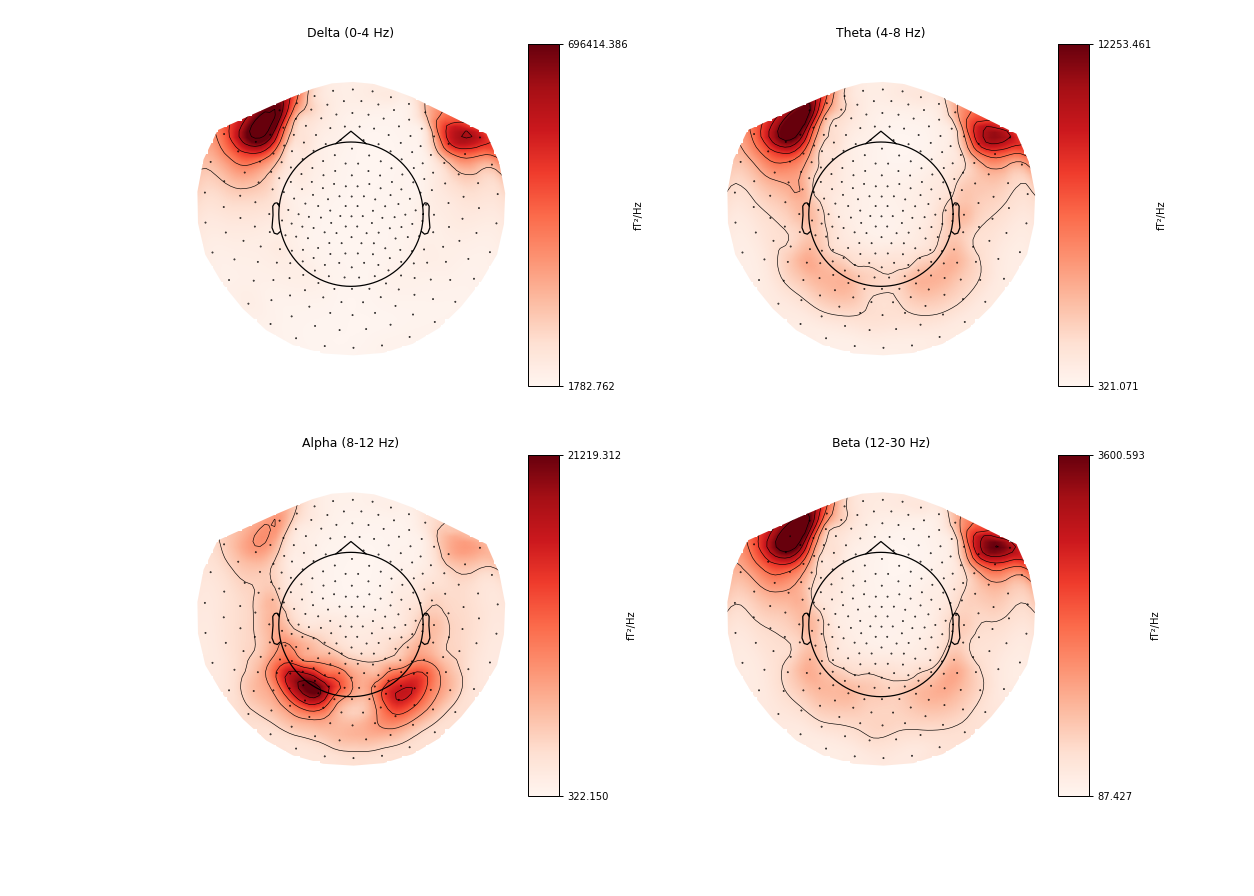

In [136]:
fig, axes = plt.subplots(figsize=(14, 10), nrows=2, ncols=2)

pres_bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
                 'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)}
band_ax = {'Delta (0-4 Hz)': axes[0, 0], 'Theta (4-8 Hz)': axes[0, 1],
                 'Alpha (8-12 Hz)': axes[1, 0], 'Beta (12-30 Hz)': axes[1, 1]}


for band in pres_bands.keys():
    
    # present current band
    spectrum.plot_topomap(bands= {band : pres_bands[band]}, size=15, ch_type="mag",
                               show_names=False,
                                extrapolate='local',
                                axes=band_ax[band],
                                show=False,
                                colorbar=False,
                                sphere=(0.0, 0.0, 0.0, 0.09))


<IPython.core.display.Javascript object>


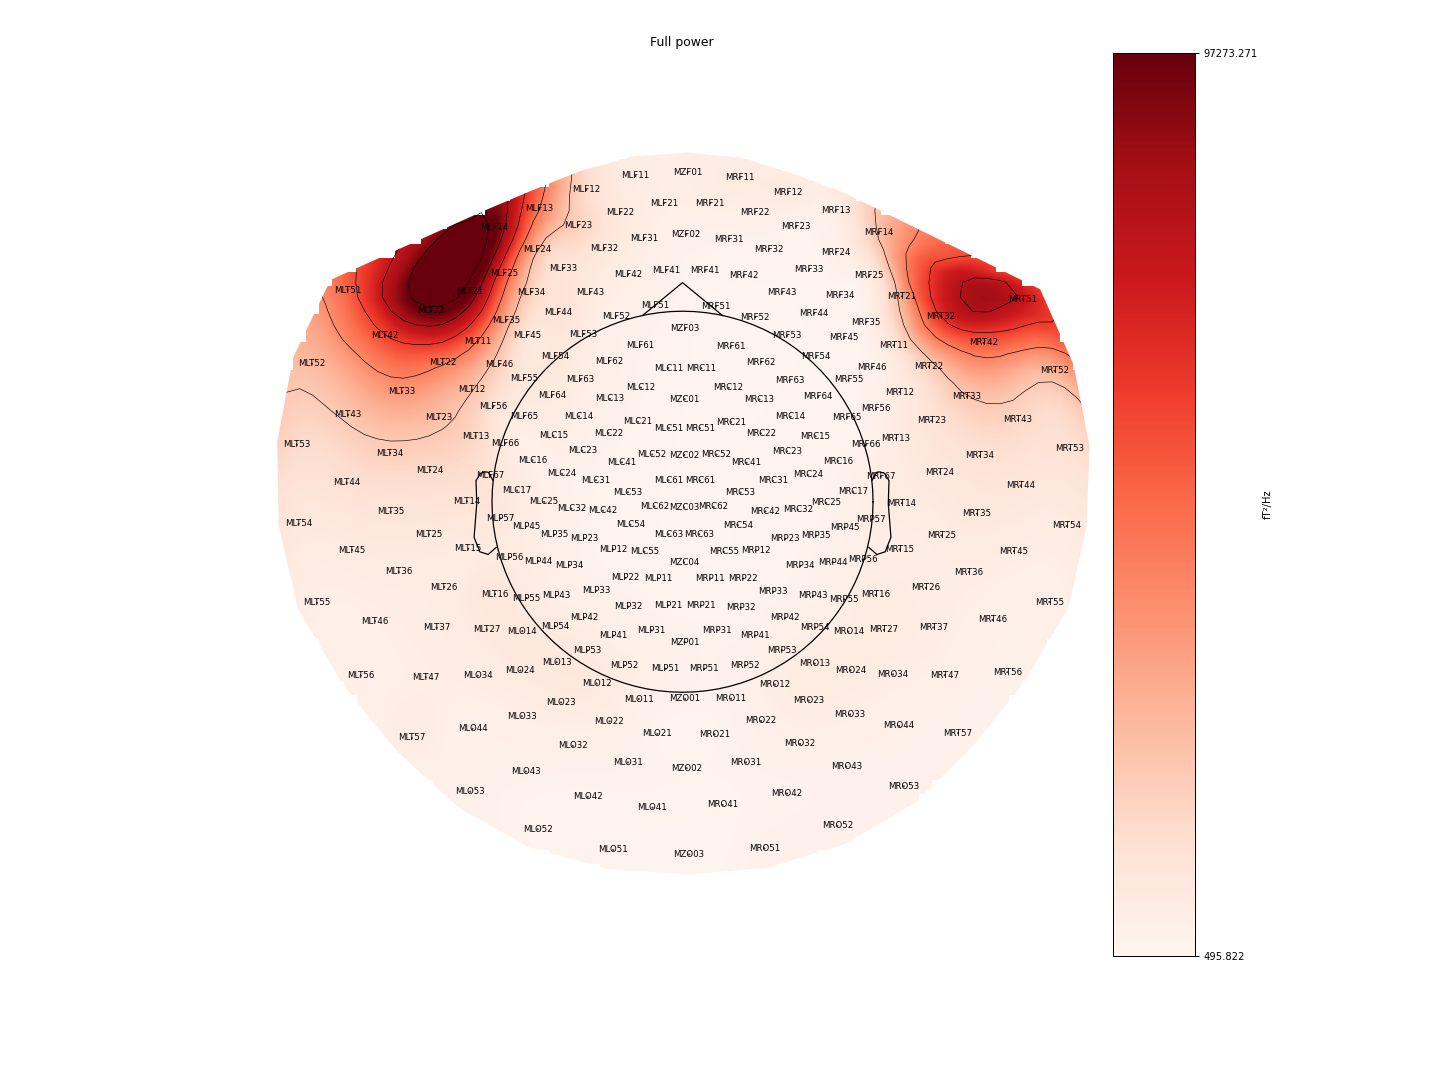

In [137]:
extrapolations = ["local", "head", "box"]
fig, ax = plt.subplots(figsize=(16, 12))

# Here we look at EEG channels, and use a custom head sphere to get all the
# sensors to be well within the drawn head surface
ax = spectrum.plot_topomap(bands= {'Full power': (0, 30)}, size=15, ch_type="mag",
                           show_names=True,
                            extrapolate='local',
                            axes=ax,
                            show=False,
                            colorbar=False,
                            sphere=(0.0, 0.0, 0.0, 0.09))


# loading log data

In [138]:
# main loading
def data_load(pp,data_dir, stim_dir):
    """load mainpred mat file and stimuli matfile"""
    mat = scipy.io.loadmat(join(data_dir,
                                f'{pp}-mainpred.mat'))
    stimuli = scipy.io.loadmat(join(stim_dir, 
                                    f'{pp}_main_stims.mat'))
    return(mat, stimuli)


def stims_load(mat, stimuli):
    """using information from stimuli and pulse timing create dataframe 
    with frequency information, pulse location etc.
    note: 'volume_rel' & 'vol_abs' are the volume where this stimuli was measured
    'closest_volume_rel' & 'closest_volume_abs' are the volume which is the closest in time
    (half tr shift) - since a tr should capture information within that tr"""

    # set arrays
    freqz   = np.array([])
    timingz  = np.array([])
    timings_offsetz  = np.array([])
    runz     = np.array([])
    blockz   = np.array([])
    segmenz  = np.array([])
    centaz   = np.array([])
    centbz   = np.array([])
    probaz   = np.array([])
    probbz   = np.array([])

    for blk in np.arange(1, mat['timingz'][1].max()+1):
        # get blockidx
        idxblock = np.where(mat['timingz'][1] == blk) # where block is 1

        #get frequency presentation data for block
        frequencies = stimuli['pres_freq'][int(blk)-1, :]

        # other values
        tps = np.sum(mat['timingz'][3, idxblock] == 1) # get trials per secion

        #get timings back from mat file, substract begin time
        timings = mat['timingz'][6, idxblock]
        timings_offset = mat['timingz'][7, idxblock]
        matidx = np.where(mat['segmentz'][1] == blk)

        # append to arrays
        freqz = np.append(freqz, frequencies)
        timingz = np.append(timingz, timings)
        timings_offsetz = np.append(timings_offsetz, timings_offset)
        runz = np.append(runz, np.repeat(mat['segmentz'][0][matidx], tps))
        blockz = np.append(blockz, np.repeat(mat['segmentz'][1][matidx], tps))
        segmenz = np.append(segmenz, np.repeat(mat['segmentz'][2][matidx], tps))
        centaz = np.append(centaz, 2**np.repeat(mat['segmentz'][7][matidx], tps))   # cent freq a
        centbz = np.append(centbz, 2**np.repeat(mat['segmentz'][8][matidx], tps))  # cent freq b
        probaz = np.append(probaz, np.repeat(mat['segmentz'][5][matidx], tps))
        probbz = np.append(probbz, np.repeat(mat['segmentz'][6][matidx], tps))

    # oct variant 
    freqz_oct = np.log2(freqz)
    centaz_oct = np.log2(centaz)
    centbz_oct = np.log2(centbz)

    # put data into a dictionary and subsequentially in a dataframe
    stim_df_dict = {'frequencies': freqz,
                    'frequencies_oct': freqz_oct,
                    'timing': timingz,
                    'timing_offset': timings_offsetz,
                    'run': runz,
                    'block': blockz,
                    'segment': segmenz,
                    'center_freq_a': centaz,
                    'center_freq_b': centbz,
                    'center_freq_a_oct': centaz_oct,
                    'center_freq_b_oct': centbz_oct,
                    'probability_a': probaz,
                    'probability_b': probbz
                   }

    stim_df = pd.DataFrame(stim_df_dict)
    # Add the 'stimulus' column to df_beh
    stim_df['stimulus'] = stim_df.index + 1
    return(stim_df)


def sync_timing(df, sync_val, timingname='timing', new_timingname='timing_meg',
                              timingname_offset='timing_offset', new_timingname_offset='timing_offset_meg'):
    """use syncing value to get timings from stimpc domain into the MEG clock domain
    input df and sync value, returns adjusted dataframe"""

    # create new column in old dataframe
    df[new_timingname] = df[timingname] + sync_val
    df[new_timingname_offset] = df[timingname_offset] + sync_val
    # and return
    return(df)

In [139]:
# load local functions
# import stim_io
# import stim_io_plotting

In [140]:
# loading the data without doing everything in python
# for surprisal move over to matlab


# within sound adaptation
# within sound predition

In [141]:
# MEG directory and file names
tasks = ['main', 'loc']
input_dir = f'/project/3018063.01/preproc/sub-{pp:03}/preproc/{tasks[task]}/'
fn = 'preproc-data-comp-cleaned-60hz.mat'




In [142]:
# set behevioural directiories
stim_dir = f'/project/3018063.01/beh/stimuli/{pp}'
loud_dir = f'/project/3018063.01/beh/loudness/{pp}'
data_dir = f'/project/3018063.01/beh/data/{pp}'

#fns
sync_fn = f'MEG_sync_sub-{pp:03d}.mat'

# load sync files
sync_mat = scipy.io.loadmat(join(data_dir, sync_fn))
sync_val = sync_mat['MEG_sync']['mn'][0][0][0,0]


In [143]:
# get mat and stimuli struct
mat, stimuli = data_load(pp, data_dir, stim_dir)

# put in dataframe
df_beh = stims_load(mat, stimuli)
df_beh = sync_timing(df_beh, sync_val)
#plt.scatter(df[df['run'].isin([1,2,3])]['timing'],df[df['run'].isin([1,2,3])]['frequencies_oct']) # plotting sanity check

In [144]:
# loading the data without doing everything in python
# for surprisal move over to matlab


# within sound adaptation
# within sound predition



In [145]:
df_beh

frequencies  frequencies_oct        timing  timing_offset   run  block  \
0       966.527296         9.916667  25298.205162   25298.407151   1.0    1.0   
1      1149.401137        10.166667  25298.455162   25298.657812   1.0    1.0   
2      1217.748086        10.250000  25298.705162   25298.906682   1.0    1.0   
3      1024.000000        10.000000  25298.955162   25299.156719   1.0    1.0   
4      2733.752021        11.416667  25299.205162   25299.407323   1.0    1.0   
...            ...              ...           ...            ...   ...    ...   
11515   683.438005         9.416667  28849.909488   28850.111294  12.0   24.0   
11516  2435.496172        11.250000  28850.159488   28850.361499  12.0   24.0   
11517  2169.780417        11.083333  28850.409488   28850.611660  12.0   24.0   
11518  2298.802275        11.166667  28850.659488   28850.861469  12.0   24.0   
11519  1625.498677        10.666667  28850.909488   28851.111668  12.0   24.0   

       segment  center_freq_a  center_freq_b  center_freq_a_oct  \
0          1.0    1077.614428     3000.00000          10.073625   
1          1.0    1077.614428     3000.00000          10.073625   
2          1.0    1077.614428     3000.00000          10.073625   
3          1.0    1077.614428     3000.00000          10.073625   
4          1.0    1077.614428     3000.00000          10.073625   
...        ...            ...            ...                ...   
11515     10.0     834.255221     2322.50571           9.704345   
11516     10.0     834.255221     2322.50571           9.704345   
11517     10.0     834.255221     2322.50571           9.704345   
11518     10.0     834.255221     2322.50571           9.704345   
11519     10.0     834.255221     2322.50571           9.704345   

       center_freq_b_oct  probability_a  probability_b  stimulus  \
0              11.550747           0.95           0.05         1   
1              11.550747           0.95           0.05         2   
2              11.550747           0.95           0.05         3   
3              11.550747           0.95           0.05         4   
4              11.550747           0.95           0.05         5   
...                  ...            ...            ...       ...   
11515          11.181466           0.05           0.95     11516   
11516          11.181466           0.05           0.95     11517   
11517          11.181466           0.05           0.95     11518   
11518          11.181466           0.05           0.95     11519   
11519          11.181466           0.05           0.95     11520   

          timing_meg  timing_offset_meg  
0       99590.813795       99591.015784  
1       99591.063795       99591.266445  
2       99591.313795       99591.515315  
3       99591.563795       99591.765352  
4       99591.813795       99592.015956  
...              ...                ...  
11515  103142.518121      103142.719927  
11516  103142.768121      103142.970132  
11517  103143.018121      103143.220293  
11518  103143.268121      103143.470102  
11519  103143.518121      103143.720301  

[11520 rows x 16 columns]

# Notes to self
* loading of MEG data within python is mostly done X
    * can take a look at pius's code to see how he handles mapping and if we can already plot something?? X
* loading of behavioural data is also done (columns x row[nr of tones]) X
    * everything is per tone, so preditors will also be like this X
    * maybe add offset timing in this dataframe as well, because this is also important X

### what we do next
next steps is to taken this behavioural df, get the log liklihood, surprisal, and experienced adaptation.
the adaptation we can take from the adaptation pipeline python code, though check for the of that stimulus variant (forward model kinda way)
the prediction we have to do with drex, be we have to do again in matlab because I dont think the matlab engine will work in python of the cluster. log liklihood/surprisal should be exactly the same as before in the MRI - we can also take the exact same parameters for the gaussian fitting etc.

after these steps we can start with the MNE toolbox fits, these might deal with the timing already without need for us to do some extra syncing of dataframes. (though syncing at this point is realatively easy)

+ log liklihood / surprisal
+ experienced adaptation     X

In [146]:
## PLOTTING FUNCTIONS


def plot_design_mat(tr_df, all_freqs, pref1, tw1, pref2, tw2, runs=1):
    """plot the desing matrix for two tuning functions specified"""
    warnings.filterwarnings('ignore')
    
    # check if runs in list, else place in list
    runs = [runs] if isinstance(runs, int) else runs

    # create subplots
    fig, ax = plt.subplots(2,
                           2,
                           figsize=(13,13), gridspec_kw={'height_ratios': [2, 3]})

    # make x the full range
    x = all_freqs

    # calculate the normal function for all frequency points
    y1 = gauss(x, pref1, tw1)
    y2 = gauss(x, pref2, tw2)

    # plot the first gaussian functions
    ax[0, 0].plot(x,y1, color='darkgreen', lw=3)

    # pimp the first gaussian function
    ax[0, 0].tick_params(axis='x', which='major', labelsize=18)               # set ticksizes x 
    ax[0, 0].tick_params(axis='y', which='major', labelsize=18)               # and y
    ax[0, 0].set_ylabel(f'Activation', fontsize=18) 
    ax[0, 0].set_xlabel(f'Freq - oct', fontsize=18) 
    ax[0, 0].spines['top'].set_visible(False)
    ax[0, 0].spines['right'].set_visible(False)
    ax[0, 0].set_title(f'Freq: {2**pref1:.1f}kHz\nTW-FWHM: {tw1 * 2.354:.2f}oct', fontsize=22)

    # plot the second gaussian fucntion
    ax[0, 1].plot(x,y2, color='darkgreen', lw=3)

    # pimp the second gaussian function
    ax[0, 1].tick_params(axis='x', which='major', labelsize=18)               # and y
    ax[0, 1].set_xlabel(f'Freq - oct', fontsize=18) 
    ax[0, 1].axes.get_yaxis().set_visible(False)
    ax[0, 1].spines['top'].set_visible(False)
    ax[0, 1].spines['right'].set_visible(False)
    ax[0, 1].spines['left'].set_visible(False)
    ax[0, 1].set_title(f'Freq: {2**pref2:.1f}kHz\nTW-FWHM: {tw2 * 2.354:.2f}oct', fontsize=22)

    # from the tuning width and tuning pref get the columns of interest
    colls = get_tw_collumns(tr_df, pref1, tw1, convolved=True)
    del colls[-2]                    # remove adapted activation
    colls += ['onoff']     # add onoff

    # plot the first heatmap 
    sns.heatmap(normalize(tr_df[colls][tr_df['run'].isin(runs)]),cmap="crest", cbar=False, 
                ax=ax[1,0])

    # pimp the first heat map
    ax[1, 0].set_ylabel(f'Trial', fontsize=18) 
    ax[1, 0].tick_params(axis='x', which='major', labelsize=14)               # set ticksizes x 
    ax[1, 0].axes.yaxis.set_ticklabels([])

    # from the second tuning widt and tuning pref get the columns of interest
    colls = get_tw_collumns(tr_df, pref2, tw2, convolved=True)
    del colls[-2]                    # remove adapted activation
    colls += ['onoff']     # add onoff

    # plot the second heatmap
    sns.heatmap(normalize(tr_df[colls][tr_df['run'].isin(runs)]),cmap="crest", cbar=False, 
                ax=ax[1,1])

    # pimp the second heat map
    ax[1, 1].axes.get_yaxis().set_visible(False)
    ax[1, 1].tick_params(axis='x', which='major', labelsize=14)               # set ticksizes x 
    fig.tight_layout()

    plt.plot()
    return(ax,fig)


def data_plot(mat, stimuli, blocknr=1, octvspace=False):
    """plot important aspects of raw data 
    optionally plot specific blocknr"""
    ## PREPAIRING DATA
    # where block is 1
    idxblock = np.where(mat['timingz'][1] == blocknr) 

    #get frequency presentation data for block
    frequencies = stimuli['pres_freq'][blocknr-1, :]

    # other values
    tps = np.sum(mat['timingz'][3, idxblock] == 1) # get trials per secion

    #get timings back from mat file, substract begin time
    timings = mat['timingz'][4, idxblock] - np.min(mat['timingz'][4, idxblock]) 

    matidx = np.where(mat['segmentz'][1] == blocknr)

    centa = 2**np.repeat(mat['segmentz'][7][matidx], tps)   # cent freq a
    centb = 2**np.repeat(mat['segmentz'][8][matidx], tps)  # cent freq b
    proba = np.repeat(mat['segmentz'][5][matidx], tps)  # prob a
    probb = np.repeat(mat['segmentz'][6][matidx], tps)  # prob b
    
    ## ACTUAL PLOTTING
    # senatry check the data
    fig, ax = plt.subplots(2, 
                           1, 
                           sharex=True,
                           gridspec_kw={'height_ratios': [3, 1]}, figsize=(10,  7.5))

    # octave transform if wanted
    if octvspace: 
        frequencies = np.log2(frequencies)
        centa = np.log2(centa)
        centb = np.log2(centb)
    
    ax[0].scatter(timings, frequencies, color='darkslategrey', alpha=0.8)
    ax[0].axhline(y=centa[0], color='darkred', linestyle='-', alpha=0.5, ls='--', lw=4)
    ax[0].axhline(y=centb[0], color='darkred', linestyle='-', alpha=0.5, ls='--', lw=4)
    ax[0].tick_params(axis='x', which='major', labelsize=18)               # set ticksizes x 
    ax[0].tick_params(axis='y', which='major', labelsize=18)               # and y
    if octvspace: space = 'octaves'
    else: space = 'Hz'
    ax[0].set_ylabel(f'Frequencies - in {space}', fontsize=18) 
    
    #ax[1].plot(timings[0], proba, color='r')
    ax[1].plot(timings[0], probb, color='darkolivegreen', lw=8)
    ax[1].tick_params(axis='x', which='major', labelsize=18)               # set ticksizes x 
    ax[1].tick_params(axis='y', which='major', labelsize=18)               # and y
    ax[1].set_xlabel('Volume', fontsize=18)
    ax[1].set_ylabel('Prob - top', fontsize=18) 
    
    # pimp plot
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.suptitle(f'Stimuli over block {blocknr}', fontsize=26)
    plt.tight_layout()
    return(ax, fig)

def stim_plot(stim_df):
    ## ACTUAL PLOTTING
    # senatry check the data
    fig, ax = plt.subplots(2, 
                           1, 
                           sharex=True,
                           gridspec_kw={'height_ratios': [3, 1]}, figsize=(10,  7.5))

    ax[0].scatter(stim_df['timing'], stim_df['frequencies_oct'], color='darkslategrey', alpha=0.8)

    ax[0].plot(stim_df['timing'], stim_df['center_freq_a_oct'], linestyle='-', alpha=0.5, lw=4)
    ax[0].plot(stim_df['timing'], stim_df['center_freq_b_oct'], linestyle='-', alpha=0.5, lw=4)

    ax[0].tick_params(axis='x', which='major', labelsize=18)               # set ticksizes x 
    ax[0].tick_params(axis='y', which='major', labelsize=18)               # and y
    ax[0].set_ylabel(f'Frequencies (oct)', fontsize=18) 

    #ax[1].plot(timings[0], proba, color='r')
    ax[1].plot(stim_df['timing'], stim_df['probability_a'], color='darkolivegreen', lw=8)
    ax[1].tick_params(axis='x', which='major', labelsize=18)               # set ticksizes x 
    ax[1].tick_params(axis='y', which='major', labelsize=18)               # and y
    ax[1].set_xlabel('Stimulus nr.', fontsize=18)
    ax[1].set_ylabel('Prob - top', fontsize=18) 

    # pimp plot
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.suptitle(f'Stimuli', fontsize=26)
    plt.tight_layout()
    
    return(ax, fig)

def freqs_plot(pref_range, sharp_range):
    """given a sharpness range and a prefference range plot all gaussians"""

    fig, ax = plt.subplots(1, 
                           1, 
                           sharex=True, figsize=(12,  3))

    # predefine size of design matrix
    y_data = np.zeros((len(pref_range), len(pref_range)*len(sharp_range)))
    idx = 0
    
    # loop over tuning widths
    for tw in sharp_range:
        # loop over prefferences
        for pref in pref_range:
            y_data[:, idx] = gauss(pref_range, pref, tw)
            idx += 1
    plt.suptitle('Used Tuning Gaussians', fontsize=26)
    plt.tight_layout()
    plt.imshow(y_data)
    return(ax, fig)

def gauss(x, x0, sigma):
    return np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [147]:
# settings
mat = scipy.io.loadmat(join(data_dir,'{}_settings_localizer.mat'.format(pp, pp)))
all_freqs = mat['cfg']['freq_array'][0][0][0,:]

# must match the tonotopy settings
tunsteps       = 10
freqstep       = 1
subsample      = np.arange(0,len(all_freqs), freqstep)
mustep         = np.diff(all_freqs[subsample])
muarray_bins   = all_freqs
muarray        = all_freqs[subsample]

# tuning sizes
fwhm           = np.linspace(1,(8), tunsteps)
octgrid        = fwhm / (2*np.sqrt(2*np.log(2)))
sigmagrid      = 2**octgrid

# set range of tunings and sharpnesses
pref_range  = muarray                # match t
sharp_range_fwhm = fwhm
sharp_range = octgrid                # check if correct, fwhm or sigma of gaussian?


## NOTE FOR FUTURE SELF: WE TAKE A OCTGRID / SHARP_RANGE BECAUSE IN THE FUTURE WE WANT TO DO PRF MAPPING FOR MEG AS WELL
## FOR NOW WE IGNORE ALL OF THAT / TROW IT AWAY AND JUST USE THE MIDDLE VALUE.. - WE COULD HAVE JUST USED [THAT VALUE]
## BUT THE DECREASE FUTURE HASSELING THIS IS EASIER

<IPython.core.display.Javascript object>


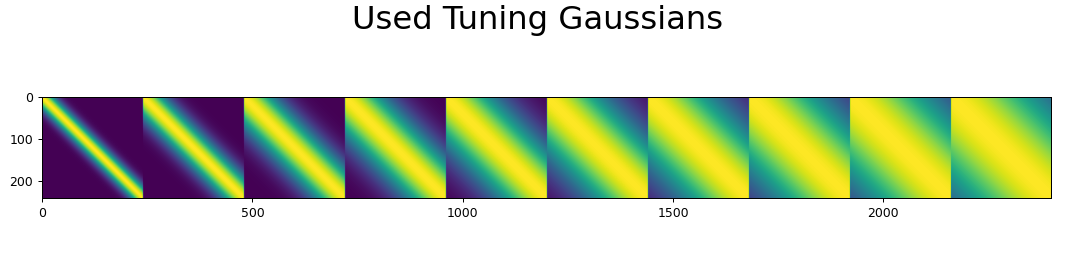

In [148]:
ax, fig = freqs_plot(pref_range, sharp_range)

### adaptation

In [149]:
def run_adaptation(stim_df, pref_range, sharp_range, y_decay):
    """wrapper functions to run adaptation model and return long matrixes of [pref*tw, stimuli]"""
    
    # calculate raw activation
    stims = stim_df['frequencies_oct'].to_numpy()
    activations = longtrace_adaptation.md_gaussian_activations(pref_range, sharp_range, stims)
    adaptations = np.zeros([len(pref_range)*len(sharp_range), len(stims)])
    n_back_adaptations = np.zeros([len(pref_range)*len(sharp_range), len(stims), len(y_decay)])

    for blk in stim_df['block'].unique():
        # get all stimuli within this block & get start and end idx of block
        stims = stim_df['frequencies_oct'][stim_df['block'] == blk].to_numpy()
        st_idx = stim_df.index[stim_df['block'] == blk][0]
        nd_idx = stim_df.index[stim_df['block'] == blk][-1] + 1

        # calculate adaptation for current block
        adaptations[:, st_idx:nd_idx], n_back_adaptations[:, st_idx:nd_idx, :] = longtrace_adaptation.md_stim_adaptation(stims, 
                                                                                                    y_decay, 
                                                                                                    pref_range, 
                                                                                                    sharp_range)

    # calculate adaptation weighted activations
    adapted_activations = np.multiply(adaptations, activations)

    return(activations, adaptations, adapted_activations, n_back_adaptations)


def adaptation_forwardmodel(stim_df, pref_range, sharp_range, adaptations, adapted_activations):
    """forward model the adaptation, given the stimulus presented get the experienced amount of adaptation, activation etc.
    input: stim_df: stimulus pandas dataframe with column ['frequencies_oct']
           pref_range: range of prefferences - must match adapations grid
           sharp_range: range of sharpnesses  - must match adapations grid
           adapations: adaptations grid
           adapted_activations: adapated activations grid
    returns:
           stim_df, with columns 'forward_adapation' and 'forward_adapted_activation'
           """

    # -- prepair grid
    # create a list of all indexes
    all_idxs = np.arange(len(pref_range) * len(sharp_range))

    # get grid of tuning pref and tuning sharpnesses
    tunprefs, tunsharps = longtrace_adaptation.md_get_tuning(all_idxs, pref_range, sharp_range)

    # -- tuning prefference grid possitioning
    # get minimum indx
    min_idx = np.argmin(np.abs(stim_df['frequencies_oct'].to_numpy()[:, np.newaxis] - pref_range), axis=1)

    # get discrete closest value back
    closest_val = pref_range[min_idx]

    # from discrete get boolean array
    pref_idx = closest_val == tunprefs[:, np.newaxis]

    # -- tuning width positioning
    # take one tw for now
    what_tw = sharp_range[5]

    # get bool array of where tw matches sellected tw
    tw_idx = np.tile(tunsharps == what_tw, (len(stim_df['frequencies_oct']), 1)).T

    # -- get logical intersection of the two
    # combine the two
    grid_idx = np.logical_and(pref_idx, tw_idx)
    grid_idx = np.argmax(grid_idx, axis=0)
    
    # save in dataframe
    stim_df['forward_adapation'] = adaptations[grid_idx, np.arange(len(grid_idx))]
    stim_df['forward_adapted_activation'] = adapted_activations[grid_idx, np.arange(len(grid_idx))]
    
    return(stim_df)

In [150]:
import adaptation.longtrace_adaptation as longtrace_adaptation
x_decay, y_decay = longtrace_adaptation.double_exp_decay_func(0.1399, 0.85, 0.0345, 6.82, [1, 10], 1)

activations, adaptations, adapted_activations, n_back_adaptations = run_adaptation(df_beh, 
                                                                                           pref_range, 
                                                                                           sharp_range, 
                                                                                           y_decay)
df_beh = adaptation_forwardmodel(df_beh, pref_range, sharp_range, adaptations, adapted_activations)

# cleanup collumns
del activations, adaptations, adapted_activations, n_back_adaptations

In [151]:
df_beh

frequencies  frequencies_oct        timing  timing_offset   run  block  \
0       966.527296         9.916667  25298.205162   25298.407151   1.0    1.0   
1      1149.401137        10.166667  25298.455162   25298.657812   1.0    1.0   
2      1217.748086        10.250000  25298.705162   25298.906682   1.0    1.0   
3      1024.000000        10.000000  25298.955162   25299.156719   1.0    1.0   
4      2733.752021        11.416667  25299.205162   25299.407323   1.0    1.0   
...            ...              ...           ...            ...   ...    ...   
11515   683.438005         9.416667  28849.909488   28850.111294  12.0   24.0   
11516  2435.496172        11.250000  28850.159488   28850.361499  12.0   24.0   
11517  2169.780417        11.083333  28850.409488   28850.611660  12.0   24.0   
11518  2298.802275        11.166667  28850.659488   28850.861469  12.0   24.0   
11519  1625.498677        10.666667  28850.909488   28851.111668  12.0   24.0   

       segment  center_freq_a  center_freq_b  center_freq_a_oct  \
0          1.0    1077.614428     3000.00000          10.073625   
1          1.0    1077.614428     3000.00000          10.073625   
2          1.0    1077.614428     3000.00000          10.073625   
3          1.0    1077.614428     3000.00000          10.073625   
4          1.0    1077.614428     3000.00000          10.073625   
...        ...            ...            ...                ...   
11515     10.0     834.255221     2322.50571           9.704345   
11516     10.0     834.255221     2322.50571           9.704345   
11517     10.0     834.255221     2322.50571           9.704345   
11518     10.0     834.255221     2322.50571           9.704345   
11519     10.0     834.255221     2322.50571           9.704345   

       center_freq_b_oct  probability_a  probability_b  stimulus  \
0              11.550747           0.95           0.05         1   
1              11.550747           0.95           0.05         2   
2              11.550747           0.95           0.05         3   
3              11.550747           0.95           0.05         4   
4              11.550747           0.95           0.05         5   
...                  ...            ...            ...       ...   
11515          11.181466           0.05           0.95     11516   
11516          11.181466           0.05           0.95     11517   
11517          11.181466           0.05           0.95     11518   
11518          11.181466           0.05           0.95     11519   
11519          11.181466           0.05           0.95     11520   

          timing_meg  timing_offset_meg  forward_adapation  \
0       99590.813795       99591.015784           1.000000   
1       99591.063795       99591.266445           0.826885   
2       99591.313795       99591.515315           0.766296   
3       99591.563795       99591.765352           0.736790   
4       99591.813795       99592.015956           0.766305   
...              ...                ...                ...   
11515  103142.518121      103142.719927           0.732701   
11516  103142.768121      103142.970132           0.706436   
11517  103143.018121      103143.220293           0.674319   
11518  103143.268121      103143.470102           0.667464   
11519  103143.518121      103143.720301           0.669098   

       forward_adapted_activation  
0                        0.999996  
1                        0.826884  
2                        0.766296  
3                        0.736788  
4                        0.766303  
...                           ...  
11515                    0.732696  
11516                    0.706431  
11517                    0.674312  
11518                    0.667458  
11519                    0.669096  

[11520 rows x 18 columns]

### pred - drex

In [152]:
#drex
def stims_export_mat(pp, input_dir, stim_df, pref_range):
    """export dataframe into mat file"""
    stim_mat = {}

    # get stimuli data
    stim_mat['stims'] = stim_df.to_dict('list')

    # aditionally get range data
    stim_mat['oct_range'] = list(pref_range)
    stim_mat['freq_range'] = list(2 ** pref_range)

    scipy.io.savemat(join(input_dir, '{}_stimdf.mat'.format(pp, pp)), stim_mat)
    return


def stims_add_drex(pp, input_dir, stim_df):
    """load drex output mat, and append to dataframe"""
    # load drex mat
    mat = scipy.io.loadmat(join(input_dir,'{}_drexdf.mat'.format(pp, pp)))

    # loop over frequencies
    collumn_names = ['pred_prob_{:.3f}'.format(frq) for frq in mat['s_range'][0]]
    temp_df = pd.DataFrame(columns=collumn_names)
    for frq in range(len(mat['s_range'][0])):
        cur_frq = mat['s_range'][0, frq]
        temp_df['pred_prob_{:.3f}'.format(cur_frq)] = mat['prob_array'][frq]

    # append surprisal and predictive probabilities
    stim_df['surprisal'] = mat['surp_array'][0]
    stim_df = pd.concat([stim_df, temp_df], axis=1)
    return(stim_df)

def stims_drex_forwardmodel(pp, input_dir, stim_df, drexfn_suffix='_drexdf.mat'):
    """forward model the adaptation, given the stimulus presented get the experienced amount of adaptation, activation etc.
    input: pp: participant number
           input_dir: what folder the drexdf.mat file is located
           stim_df: stimulus pandas dataframe with column ['frequencies_oct']
           drexfn_suffix(optional): suffix of the drexfilename
    returns:
           stim_df, with columns 'surprisal' and 'pred_prob'
           """
    # load drex mat
    mat = scipy.io.loadmat(join(input_dir,'{}{}'.format(pp, drexfn_suffix)))
    tunprefs = mat['s_range'][0]

    # get minimum indx
    min_idx = np.argmin(np.abs(stim_df['frequencies_oct'].to_numpy()[:, np.newaxis] - tunprefs), axis=1)

    # add surprisal and pred prob
    stim_df['surprisal']  = mat['surp_array'][0]
    stim_df['pred_prob']  = mat['prob_array'][min_idx, np.arange(len(min_idx))]

    return(stim_df)

In [153]:
stims_export_mat(pp, data_dir, df_beh, pref_range)

# MATLAB FUNCTION : rundrex_stims(pp, input_dir)
# MATLAB WRAPPER FUNCTION : rundrex_bulk

df_beh = stims_drex_forwardmodel(pp, data_dir, df_beh)


# reexport dataframe with drex data in it
stims_export_mat(pp, data_dir, df_beh, pref_range)

In [154]:
df_beh

frequencies  frequencies_oct        timing  timing_offset   run  block  \
0       966.527296         9.916667  25298.205162   25298.407151   1.0    1.0   
1      1149.401137        10.166667  25298.455162   25298.657812   1.0    1.0   
2      1217.748086        10.250000  25298.705162   25298.906682   1.0    1.0   
3      1024.000000        10.000000  25298.955162   25299.156719   1.0    1.0   
4      2733.752021        11.416667  25299.205162   25299.407323   1.0    1.0   
...            ...              ...           ...            ...   ...    ...   
11515   683.438005         9.416667  28849.909488   28850.111294  12.0   24.0   
11516  2435.496172        11.250000  28850.159488   28850.361499  12.0   24.0   
11517  2169.780417        11.083333  28850.409488   28850.611660  12.0   24.0   
11518  2298.802275        11.166667  28850.659488   28850.861469  12.0   24.0   
11519  1625.498677        10.666667  28850.909488   28851.111668  12.0   24.0   

       segment  center_freq_a  center_freq_b  center_freq_a_oct  \
0          1.0    1077.614428     3000.00000          10.073625   
1          1.0    1077.614428     3000.00000          10.073625   
2          1.0    1077.614428     3000.00000          10.073625   
3          1.0    1077.614428     3000.00000          10.073625   
4          1.0    1077.614428     3000.00000          10.073625   
...        ...            ...            ...                ...   
11515     10.0     834.255221     2322.50571           9.704345   
11516     10.0     834.255221     2322.50571           9.704345   
11517     10.0     834.255221     2322.50571           9.704345   
11518     10.0     834.255221     2322.50571           9.704345   
11519     10.0     834.255221     2322.50571           9.704345   

       center_freq_b_oct  probability_a  probability_b  stimulus  \
0              11.550747           0.95           0.05         1   
1              11.550747           0.95           0.05         2   
2              11.550747           0.95           0.05         3   
3              11.550747           0.95           0.05         4   
4              11.550747           0.95           0.05         5   
...                  ...            ...            ...       ...   
11515          11.181466           0.05           0.95     11516   
11516          11.181466           0.05           0.95     11517   
11517          11.181466           0.05           0.95     11518   
11518          11.181466           0.05           0.95     11519   
11519          11.181466           0.05           0.95     11520   

          timing_meg  timing_offset_meg  forward_adapation  \
0       99590.813795       99591.015784           1.000000   
1       99591.063795       99591.266445           0.826885   
2       99591.313795       99591.515315           0.766296   
3       99591.563795       99591.765352           0.736790   
4       99591.813795       99592.015956           0.766305   
...              ...                ...                ...   
11515  103142.518121      103142.719927           0.732701   
11516  103142.768121      103142.970132           0.706436   
11517  103143.018121      103143.220293           0.674319   
11518  103143.268121      103143.470102           0.667464   
11519  103143.518121      103143.720301           0.669098   

       forward_adapted_activation  surprisal  pred_prob  
0                        0.999996  12.356327   0.189240  
1                        0.826884  11.954444   0.264087  
2                        0.766296  11.410387   0.388818  
3                        0.736788  10.872879   0.559243  
4                        0.766303  14.188083   0.046364  
...                           ...        ...        ...  
11515                    0.732696  14.133631   0.057823  
11516                    0.706431  10.506296   0.683203  
11517                    0.674312  10.287111   0.800868  
11518                    0.667458  10.306562   0.786836  
11519                    0.66

In [155]:
def zscore_columns(df, columns):
    """
    Z-score the specified columns of a pandas df
    input:
        df: A pandas DataFrame.
        columns: A list of column names to be z-scored.
    returns: A DataFrame with the specified columns z-scored.
    """
    # zscore the sellected collumns
    df[columns] = (df[columns] - df[columns].mean()) / df[columns].std()
    return df

# zscore some collumns
df_beh = zscore_columns(df_beh, ['forward_adapation', 'forward_adapted_activation', 'surprisal', 'pred_prob'])

# on off putting in timing dataframe

In [156]:
df_beh[['timing_meg', 'timing_offset_meg']]

timing_meg  timing_offset_meg
0       99590.813795       99591.015784
1       99591.063795       99591.266445
2       99591.313795       99591.515315
3       99591.563795       99591.765352
4       99591.813795       99592.015956
...              ...                ...
11515  103142.518121      103142.719927
11516  103142.768121      103142.970132
11517  103143.018121      103143.220293
11518  103143.268121      103143.470102
11519  103143.518121      103143.720301

[11520 rows x 2 columns]

In [157]:
df_beh['block'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])

In [158]:
# put 'frequencies', 'frequencies_oct',  'run', 'segment', 'center_freq_a', 'center_freq_b',
#        'center_freq_a_oct', 'center_freq_b_oct', 'probability_a',
#        'probability_b',  'forward_adapation',
#        'forward_adapted_activation', 'surprisal', 'pred_prob'
# into df (for MEG data)

In [159]:
import time

## transformation into the time domain

In [160]:
## MOVE FUNCTIONS FROM STIMULUS DOMAIN INTO TIMEDOMAIN
## MAP 'STIMULUS' TO INDEX OF WHAT STIMULI, FOR EASY MAPPING

def stim_save_segments(df_beh, groupby_nm=['block', 'segment']):
    """apply a new column to behavioural dataframe with segment_all - 
    indicating a continious numerical indicator of what segment we are on"""

    # predefine segement all in df_beh
    df_beh['segment_all'] = np.nan
    
    # loop over block and segment combinations
    for idx, row in df_beh.groupby(groupby_nm).first().reset_index().iterrows():

        # save new segment all 
        df_beh.loc[(df_beh['block'] == row['block']) & (df_beh['segment'] == row['segment']), 'segment_all'] = idx 

    # return the dataframe
    return(df_beh)


def map_stim_to_time(df, df_beh, cn_stim='stimulus', cn_ts='TIMESTAMP', 
                     beh_cn_onset='timing_meg', beh_cn_offset='timing_offset_meg'):
    """transform / map stimulus dataframe into the time domain
    input: df: Pandas dataframe - time domain
           df_beh: Pandas dataframe - stim domain
           cn_stim: (optional) column name for stimulus indicator
           cn_ts: (optional) column name for timestamp indicater in time df
           beh_cn_onset: (optional) column name for onset time in beh_df
           beh_cn_offset: (optional) column name for offset time in beh_df"""
    
    # Apply the function to create the 'stimulus' column in df_time
    df['stimulus'] = df['TIMESTAMP'].apply(_assign_stimulus, 
                                           df_beh=df_beh,
                                           cn_onset=beh_cn_onset,
                                           cn_offset=beh_cn_offset,
                                           cn_stimulus=cn_stim)
    # Return the dataframe
    return(df)


def map_columns_to_time(df, df_beh, col_to_trans, indicator_nm='stimulus'):
    """map columns of interest to transfer to timedomain
    df: dataframe in timedomain
    df_beh: dataframe in stim domain
    col_to_trans: all columns to transfer
    indicator_nm: (optional) indicator name - what to use for the mapping"""
    
    # loop over columns to transfer
    for colnm in col_to_trans:

        # create a dictionary to map 'stimulus' to all conditions I want to transfer to the other df
        stimulus_to_col = df_beh.set_index(indicator_nm)[colnm].to_dict()

        # map function to go from one to another
        df[colnm] = df[indicator_nm].map(stimulus_to_col).fillna(0)
        
    # returns dataframe
    return(df)


def map_block_to_run(df, df_beh, run_nm='run', block_nm_beh='block', block_nm='BLOCK'):
    """map from blocknumber to run number in timedomain"""

    # create a dictionary to map 'block' to run
    map_block_run = df_beh.set_index(block_nm_beh)[run_nm].to_dict()

    # map the df
    df[run_nm] = df[block_nm].map(map_block_run).fillna(0).astype(int)

    # return dataframe
    return(df)


def time_save_segments(df, df_beh,
                       groupby_nm=['block', 'segment'],
                       onset_nm='timing_meg',
                       offset_nm='timing_offset_meg',
                       timing_mm='TIMESTAMP'
                      ):
    """save segments into the time domain dataframe
    df: timedomain dataframe
    df_beh: stimdomain dataframe
    groupby_nm: (optional) list of names to groupby
    onset_nm: (optional) what to use as onset timings - in same timeframe
    offset_nm: (optional) what to use as offset timings - in same timeframe
    timing_nm: (optional) time indicator in original dataframe"""

    # get dataframe of onset and offset timings only
    onset_df = df_beh.groupby(groupby_nm).first()[onset_nm].reset_index()
    offset_df = df_beh.groupby(groupby_nm).last()[offset_nm].reset_index()

    # predefine all new columns in our timedomain dataframe
    df['block'] = np.nan
    df['segment'] = np.nan
    df['segment_all'] = np.nan

    # loop over all index (combinations)
    for idx, row in onset_df.iterrows():

        # get start and endtime of groupby section
        cur_onset = onset_df[onset_nm].iloc[idx]
        cur_offset = offset_df[offset_nm].iloc[idx]

        # map to OG dataframe
        df.loc[(df[timing_mm] >= cur_onset) & (df[timing_mm] <= cur_offset), 'segment'] = onset_df['segment'].iloc[idx]

        # save per segment indicator
        df.loc[(df[timing_mm] >= cur_onset) & (df[timing_mm] <= cur_offset), 'segment_all'] = idx
    
    return(df)


def time_save_onoff(df, onoff_nm='onoff', indicator='stimulus'):
    """save onoff value (bool), based on indicator value"""

    # predefine
    df['onoff'] = 0
    # take wherever there is any stimulus - set to 1
    df.loc[(df['stimulus'] > 0), 'onoff'] = 1
    
    return(df)


# create a function to assign stimuli based on timing
def _assign_stimulus(timing, 
                     df_beh, 
                     cn_onset='timing_meg', 
                     cn_offset='timing_offset_meg',
                     cn_stimulus='stimulus'):
    """pandas apply function to get stimuli into the time domain
    input df_beh, cn_onset (optional columnname of onset time),
    cn_offset (optional columnname of offset time), cn_stimulus (optional columnname of stimulus)"""
    idx = np.searchsorted(df_beh[cn_onset], timing)
    if idx == 0 or timing >= df_beh[cn_offset].iloc[idx - 1]:
        return 0
    return df_beh[cn_stimulus].iloc[idx - 1]


In [161]:
# map stimulus indexing to timedomain (123 > 00011100222000333)
df = map_stim_to_time(df, df_beh, cn_stim='stimulus', cn_ts='TIMESTAMP', 
                     beh_cn_onset='timing_meg', beh_cn_offset='timing_offset_meg')

# get columns of interest to transfer and apply stim specific mapping
col_to_trans = ['frequencies', 'frequencies_oct', 'forward_adapation', 'forward_adapted_activation', 'surprisal', 'pred_prob']
# col_to_trans = ['frequencies', 'frequencies_oct', 'forward_adapation', 'forward_adapted_activation']

df = map_columns_to_time(df, df_beh, col_to_trans)

# save segment and segment all in timedomain and segment all in main stimulus domain dataframe
df = time_save_segments(df, df_beh)
df_beh = stim_save_segments(df_beh)

# use the blocknumber to runnumber pairing in stimulus domain to map block to run in time domain
df = map_block_to_run(df, df_beh)

# map segment specific data onto current segment
col_to_trans = ['center_freq_a', 'center_freq_b', 'center_freq_a_oct', 'center_freq_b_oct', 'probability_a', 'probability_b']
df = map_columns_to_time(df, df_beh, col_to_trans, indicator_nm='segment_all')

# save onoff inside timing dataframe
df = time_save_onoff(df)

In [162]:
## function to get inblock boolean
## TODO: MAKE IN SIMPLE FUNCTION

# Find start and end timings for each block
block_timings = df_beh.groupby('block')['timing_meg'].agg(['min', 'max'])

# predefine inblock bool
df['in_block'] = False

# loop over rows
for _, row in block_timings.iterrows():
    # Find the index of the closest TIMESTAMP value to the min and max timing
    min_idx = (df['TIMESTAMP'] - row['min']).abs().idxmin()
    max_idx = (df['TIMESTAMP'] - row['max']).abs().idxmin()
    
    # Set the in_block column to True for the range between min_idx and max_idx
    df.loc[min_idx:max_idx, 'in_block'] = True

## Get all data again but for only onset time - impulse

In [163]:
def time_transform_FIR(df, indicator, fir_columns,
                       prefix_fir = 'FIR_',
                       prefix_fir_offset = 'OFFSET_FIR_'):
    """within a dataframe, groupby indicator > loop over fir columns and make a boxplot a impulse (start + end)
    input: df: timedomain dataframe
           indicator: indicator for groupby (unqiue indicator that binds the fir_columns)
           fir_columns: the fir columns to loop over and add
           prefix_fir: (optional) prefix naming for new fir naming
           prefix_fir_offset: (optional) prefix naming for new fir ofset naming
    return: return adjusted dataframe
    """

    # create onset and ofset arrays for FIR modelling - per stimulus
    onset_idx  = df[df[indicator] > 0].groupby(indicator).apply(lambda x: x.index[0]).to_numpy()  # onset
    offset_idx = df[df[indicator] > 0].groupby(indicator).apply(lambda x: x.index[-1]).to_numpy() # offset

    # loop over columns of interest to re-insert into df as FIR
    for col in fir_columns:

        # predefine columns
        df[f'{prefix_fir}{col}'] = 0
        df[f'{prefix_fir_offset}{col}'] = 0

        # take first or last value from boxplot and make FIR
        df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
        df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
        
    return(df)

In [164]:
# get columns we want to take first instanse impulse for 
fir_columns  =  ['frequencies', 
                'frequencies_oct',
                'forward_adapation',
                'forward_adapted_activation',
                'surprisal',
                'pred_prob',
                'onoff']
# fir_columns  =  ['frequencies', 
#                 'frequencies_oct',
#                 'forward_adapation',
#                 'forward_adapted_activation',
#                 'onoff']

# add fir impulses to dataframe
df = time_transform_FIR(df, 'stimulus', fir_columns)
df = time_transform_FIR(df, 'BLOCK', ['BLOCK'])
df = time_transform_FIR(df, 'segment_all', ['segment_all'])

In [165]:
df

MLC11         MLC12         MLC13         MLC14         MLC15  \
0      -2.645107e-14  6.567030e-14  1.021934e-13  1.956989e-13  3.067283e-13   
1      -6.645921e-14  7.874450e-14  1.673952e-13  3.444168e-13  5.894372e-13   
2      -7.733844e-14  2.453510e-14  1.673419e-13  2.894187e-13  5.286423e-13   
3       6.979738e-14  1.499843e-13  2.559532e-13  3.357482e-13  5.239853e-13   
4      -1.519247e-13 -6.885257e-14  2.345664e-14  1.913181e-13  4.207425e-13   
...              ...           ...           ...           ...           ...   
179905  1.052564e-13  3.952711e-13  7.063515e-13  8.770763e-13  1.044724e-12   
179906 -8.187242e-15  2.738728e-13  5.218844e-13  6.709288e-13  8.080707e-13   
179907 -6.897533e-14  2.565290e-13  5.234191e-13  7.579913e-13  9.242586e-13   
179908 -2.238426e-14  2.885495e-13  5.684718e-13  8.240940e-13  1.013364e-12   
179909  8.822173e-14  4.150417e-13  7.067252e-13  9.435181e-13  1.095714e-12   

               MLC16         MLC17         MLC21         MLC22         MLC23  \
0       3.160692e-13  4.930232e-13  6.001226e-14  8.271145e-14  1.971272e-13   
1       6.149488e-13  8.490748e-13  4.389667e-14  9.963625e-14  4.138111e-13   
2       5.650244e-13  8.163693e-13  3.420707e-14  7.226092e-14  3.396960e-13   
3       6.304842e-13  9.964474e-13  1.902093e-13  1.649268e-13  4.099806e-13   
4       5.691492e-13  8.941836e-13 -2.356525e-14  9.517515e-15  2.528554e-13   
...              ...           ...           ...           ...           ...   
179905  6.922856e-13  8.157767e-13  4.654256e-13  5.867639e-13  7.245774e-13   
179906  4.985766e-13  4.930858e-13  3.383241e-13  4.337676e-13  5.529529e-13   
179907  6.203083e-13  6.773739e-13  3.265702e-13  4.832332e-13  5.673974e-13   
179908  6.793531e-13  7.800659e-13  3.574954e-13  5.147138e-13  6.715447e-13   
179909  7.471931e-13  8.715431e-13  4.842415e-13  6.272982e-13  8.009027e-13   

        ...  FIR_surprisal  OFFSET_FIR_surprisal  FIR_pred_prob  \
0       ...            0.0                   0.0            0.0   
1       ...            0.0                   0.0            0.0   
2       ...            0.0                   0.0            0.0   
3       ...            0.0                   0.0            0.0   
4       ...            0.0                   0.0            0.0   
...     ...            ...                   ...            ...   
179905  ...            0.0                   0.0            0.0   
179906  ...            0.0                   0.0            0.0   
179907  ...            0.0                   0.0            0.0   
179908  ...            0.0                   0.0            0.0   
179909  ...            0.0                   0.0            0.0   

        OFFSET_FIR_pred_prob  FIR_onoff  OFFSET_FIR_onoff  FIR_BLOCK  \
0                        0.0          0                 0          1   
1                        0.0          0                 0          0   
2                        0.0          0                 0          0   
3                        0.0          0                 0          0   
4                        0.0          0                 0          0   
...                      ...        ...               ...        ...   
179905                   0.0          0                 0          0   
179906                   0.0          0                 0          0   
179907                   0.0          0                 0          0   
179908                   0.0          0                 0          0   
179909                   0.0          0                 0          0   

        OFFSET_FIR_BLOCK  FIR_segment_all  OFFSET_FIR_segment_all  
0                      0                0                       0  
1                      0                0                       0  
2                      0                0                       0  
3                      0                0                       0  
4                      0                0                       0  
...            

# try out FIR modelling

In [166]:
ft_meeg_data['sfreq']

60.0

+ in principle we can simply timeshift these points in the window we want [-before_onset +after_onset]
+ for this we take 1/`ft_meeg_data['sfreq']` into account 
    + e.g 0.1/(60**-1) = 6 timesteps before onset
    + e.g.0.4/(60**-1) = 24 timesteps after onset
+ we can do this by simply .shift the dataframe, however, many of these toolboxes probably have this buildin
+ try this and plot the designmatrix
    + additionally plot the 0th time (onset time) horizontal line
    
    
also:
CHECK IF `EELBRAIN` WAS INSTALLED SUCCESFULLY, AND IF NOT TRY TO FIX

In [167]:
def add_event_from_df(raw, df, event_nm):
    """within the raw MNE object, using the matching nonzero indexes in df to add mne events
    input: raw: mne raw object - must include 'sfreq', here we add stim to
            df: dataframe with our stimulus (impulse/block) information
            event_nm: the name of the column in the dataframe which is the event
    output: returns raw mne object with object"""

    # calulate index position of events and the value of those events
    idxs      = np.where(df[event_nm] > 0)
    value     = df[event_nm].to_numpy()[idxs]

    # predefine numpy array in correct shape for mne
    mne_arr = np.zeros((len(idxs[0]), 3))
    mne_arr[:,0] = idxs[0]
    mne_arr[:,2] = value

    # # create new stimulus channel - ONOFF
    if event_nm not in raw.ch_names:
        temp_info = mne.create_info([event_nm], raw.info['sfreq'], ['stim'])
        stim_raw = mne.io.RawArray(df[[event_nm]].to_numpy().T, temp_info)
        raw.add_channels([stim_raw], force_update_info=True)

    # add actuall events
    raw.add_events(mne_arr, stim_channel=event_nm, replace=True)
    return(raw)

In [168]:
event_columns = ['FIR_frequencies', 
                'FIR_frequencies_oct',
                'FIR_forward_adapation',
                'FIR_forward_adapted_activation',
                'FIR_surprisal',
                'FIR_pred_prob',
                'FIR_onoff',
                'onoff']
# event_columns = ['FIR_frequencies', 
#                 'FIR_frequencies_oct',
#                 'FIR_forward_adapation',
#                 'FIR_forward_adapted_activation',
#                 'FIR_onoff',
#                 'onoff']

# add events for all 
for evnt in event_columns:
    raw = add_event_from_df(raw, df, evnt)

Creating RawArray with float64 data, n_channels=1, n_times=179910
    Range : 0 ... 179909 =      0.000 ...  2998.483 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179910
    Range : 0 ... 179909 =      0.000 ...  2998.483 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179910
    Range : 0 ... 179909 =      0.000 ...  2998.483 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179910
    Range : 0 ... 179909 =      0.000 ...  2998.483 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179910
    Range : 0 ... 179909 =      0.000 ...  2998.483 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179910
    Range : 0 ... 179909 =      0.000 ...  2998.483 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179910
    Range : 0 ... 179909 =      0.000 ...  2998.483 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179910
    Range : 0 ... 179909

In [169]:
# raw_planar = mne.preprocessing.compute_current_source_density(raw)
# raw

# testing transformation

11520 events found
Event IDs: [1]
Not setting metadata
11520 matching events found
Removing 1280 compensators from info because not all compensation channels were picked.
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11520 events and 37 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (10323 targets, 1 regressors)


/scratch/jorvhar/50550017.dccn-l029.dccn.nl/ipykernel_28927/1578522404.py:14: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fir_surprisal_data[fir_surprisal_data > 0, np.newaxis], names=['FIR_onoff'])


Done


<IPython.core.display.Javascript object>


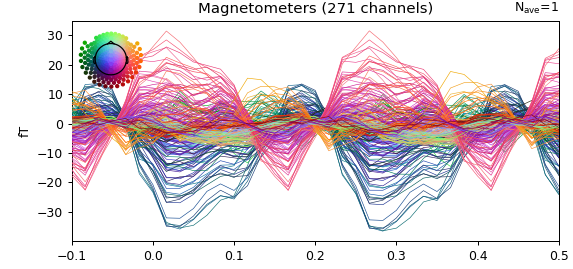

<IPython.core.display.Javascript object>


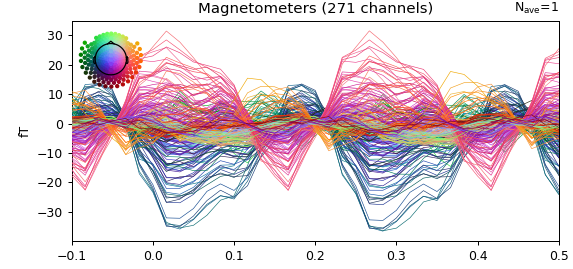

In [170]:
import mne
from mne.stats import linear_regression

# Find events
events = mne.find_events(raw, stim_channel='FIR_onoff')

# Create epochs
epochs = mne.Epochs(raw, events, tmin=-0.1, tmax=0.5, preload=True)

# Get the data for the 'fir_surprisal' channel
fir_surprisal_data = raw.copy().pick_channels(['FIR_onoff']).get_data()

# Perform linear regression
res = linear_regression(epochs, fir_surprisal_data[fir_surprisal_data > 0, np.newaxis], names=['FIR_onoff'])

# Access the beta values and related information
beta_values = res['FIR_onoff'].beta#.as_type("grad")
t_values = res['FIR_onoff'].t_val#.as_type("grad")
p_values = res['FIR_onoff'].p_val#.as_type("grad")

# Access and plot the beta values directly
res['FIR_onoff'].beta.plot()

11520 events found
Event IDs: [1]
Not setting metadata
11520 matching events found
Removing 1280 compensators from info because not all compensation channels were picked.
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11520 events and 37 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (10323 targets, 1 regressors)


/scratch/jorvhar/50550017.dccn-l029.dccn.nl/ipykernel_28927/2253020722.py:14: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fir_surprisal_data[fir_surprisal_data > 0, np.newaxis], names=['FIR_onoff'])


Done


<IPython.core.display.Javascript object>


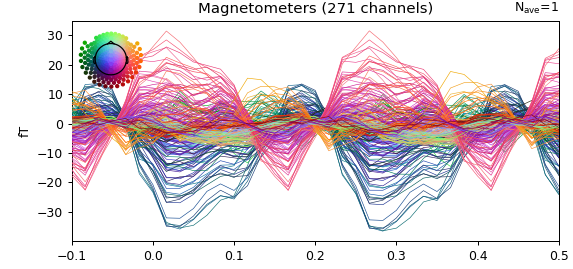

<IPython.core.display.Javascript object>


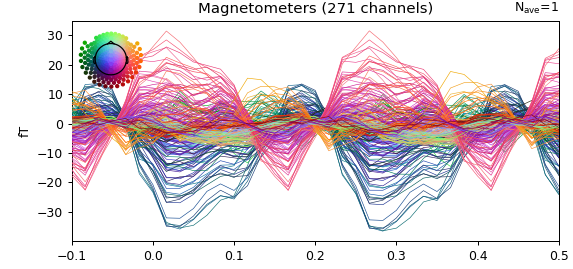

In [171]:
import mne
from mne.stats import linear_regression

# Find events
events = mne.find_events(raw, stim_channel='FIR_onoff')

# Create epochs
epochs = mne.Epochs(raw, events, tmin=-0.1, tmax=0.5, preload=True)

# Get the data for the 'fir_surprisal' channel
fir_surprisal_data = raw.copy().pick_channels(['FIR_onoff']).get_data()

# Perform linear regression
res = linear_regression(epochs, fir_surprisal_data[fir_surprisal_data > 0, np.newaxis], names=['FIR_onoff'])

# Convert the results to gradiometers
res_as_grad = res.copy()
res_as_grad.update({'grad': True})  # Set the 'grad' channel type

# Access and plot the beta values directly in grad
res_as_grad['FIR_onoff'].beta.plot()


11520 events found
Event IDs: [1]
Not setting metadata
11520 matching events found
Removing 1280 compensators from info because not all compensation channels were picked.
Setting baseline interval to [-0.05, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11520 events and 28 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (7812 targets, 1 regressors)


/scratch/jorvhar/50550017.dccn-l029.dccn.nl/ipykernel_28927/38426690.py:36: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res_high = linear_regression(high_fir_epochs, event_vals[mask_high, np.newaxis], names=['FIR_onoff'])


Done


<IPython.core.display.Javascript object>


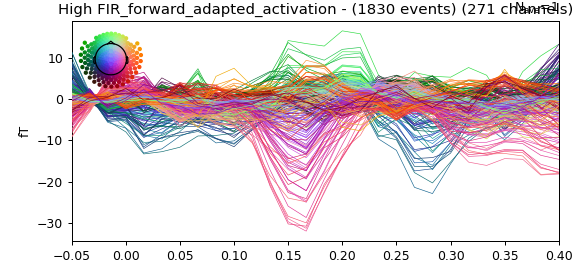

Fitting linear model to epochs, (7812 targets, 1 regressors)


/scratch/jorvhar/50550017.dccn-l029.dccn.nl/ipykernel_28927/38426690.py:42: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res_low = linear_regression(low_fir_epochs, event_vals[mask_low, np.newaxis], names=['FIR_onoff'])


Done


<IPython.core.display.Javascript object>


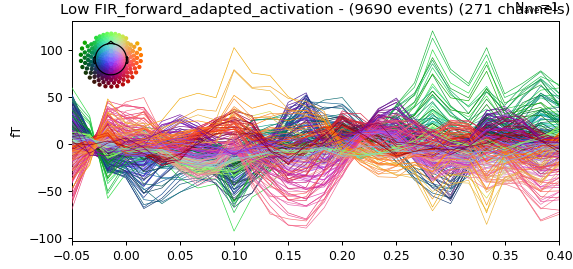

In [172]:
"""split data of low vs high surprisal events, using simple event related averaging"""

split_oi = 'FIR_forward_adapted_activation'
upperb = 0.8
lowerb = 0.8

import mne
from mne.stats import linear_regression
import numpy as np

# Find events
events = mne.find_events(raw, stim_channel='FIR_onoff')

# Create epochs
epochs = mne.Epochs(raw, events, tmin=-0.05, tmax=0.4, preload=True)

# Get the data for the 'FIR_surprisal' channel
fir_surprisal_data = raw.copy().pick_channels(['FIR_onoff']).get_data()

# get the data for the fir surprisal channel to be use for splitting
surprisal_d = raw.copy().pick_channels([split_oi]).get_data()

# Extract values corresponding to the event times
event_vals = surprisal_d[0, events[:, 0]]

# Create masks based on the extracted values
mask_high = event_vals > upperb
mask_low = event_vals <= lowerb

# Split epochs based on the mask
high_fir_epochs = epochs[mask_high]
low_fir_epochs = epochs[mask_low]


# Perform linear regression for the high 'FIR_surprisal' values
res_high = linear_regression(high_fir_epochs, event_vals[mask_high, np.newaxis], names=['FIR_onoff'])

# Access and plot the beta values for high 'FIR_surprisal'
res_high['FIR_onoff'].beta.plot(titles=f'High {split_oi} - ({mask_high.sum()} events)')

# Perform linear regression for the low 'FIR_surprisal' values
res_low = linear_regression(low_fir_epochs, event_vals[mask_low, np.newaxis], names=['FIR_onoff'])

# Access and plot the beta values for low 'FIR_surprisal'
res_low['FIR_onoff'].beta.plot(titles=f'Low {split_oi} - ({mask_low.sum()} events)');

11520 events found
Event IDs: [1]
Not setting metadata
11520 matching events found
Removing 1280 compensators from info because not all compensation channels were picked.
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11520 events and 37 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (10323 targets, 1 regressors)


/scratch/jorvhar/50550017.dccn-l029.dccn.nl/ipykernel_28927/3792238517.py:14: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fir_surprisal_data[fir_surprisal_data > 0, np.newaxis], names=['FIR_onoff'])


Done


<IPython.core.display.Javascript object>


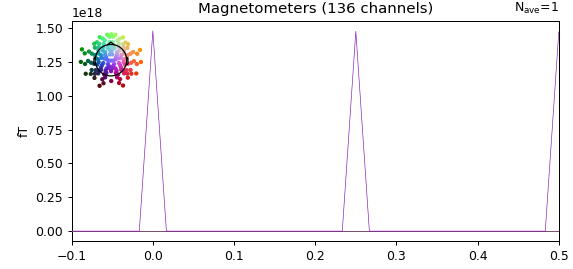

<IPython.core.display.Javascript object>


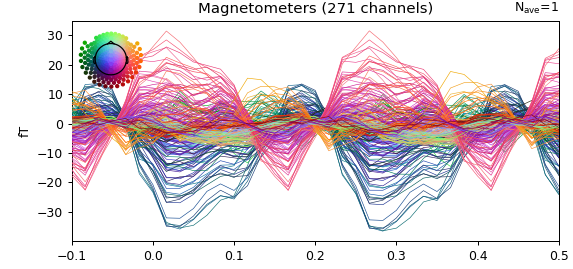

In [173]:
import mne
from mne.stats import linear_regression

# Find events
events = mne.find_events(raw, stim_channel='FIR_onoff')

# Create epochs
epochs = mne.Epochs(raw, events, tmin=-0.1, tmax=0.5, preload=True)

# Get the data for the 'fir_surprisal' channel
fir_surprisal_data = raw.copy().pick_channels(['FIR_onoff']).get_data()

# Perform linear regression
res = linear_regression(epochs, fir_surprisal_data[fir_surprisal_data > 0, np.newaxis], names=['FIR_onoff'])

# Access the beta values and related information
beta_values = res['FIR_onoff'].beta
t_values = res['FIR_onoff'].t_val
p_values = res['FIR_onoff'].p_val

# Access and plot the beta values directly

abc = magplanar_proxy(res['FIR_onoff'].beta)
abc.plot()

res['FIR_onoff'].beta.plot();

In [174]:
# plt.plot(df['FIR_segment_all'].head(2000))
event_columns = ['FIR_segment_all',
                'OFFSET_FIR_segment_all',
                 'FIR_BLOCK']

# add events for all 
for evnt in event_columns:
    raw = add_event_from_df(raw, df, evnt)

Creating RawArray with float64 data, n_channels=1, n_times=179910
    Range : 0 ... 179909 =      0.000 ...  2998.483 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179910
    Range : 0 ... 179909 =      0.000 ...  2998.483 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179910
    Range : 0 ... 179909 =      0.000 ...  2998.483 secs
Ready.


239 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239]
N

/scratch/jorvhar/50550017.dccn-l029.dccn.nl/ipykernel_28927/2539967350.py:14: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fir_surprisal_data[fir_surprisal_data > 0, np.newaxis], names=['OFFSET_FIR_segment_all'])


Done


<IPython.core.display.Javascript object>


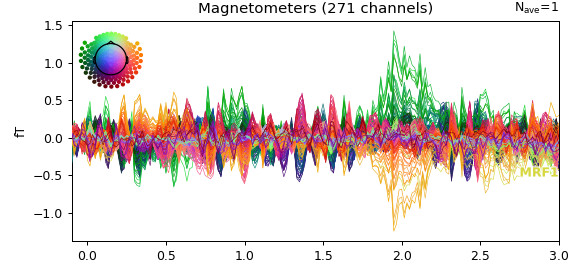

<IPython.core.display.Javascript object>


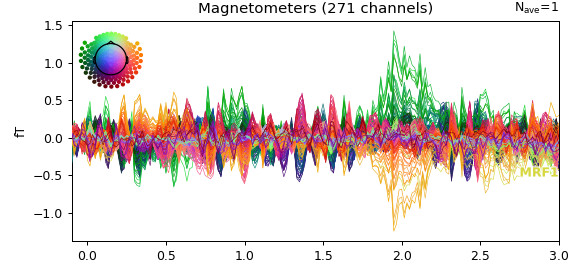

In [175]:
import mne
from mne.stats import linear_regression

# Find events
events = mne.find_events(raw, stim_channel='OFFSET_FIR_segment_all')

# Create epochs
epochs = mne.Epochs(raw, events, tmin=-0.1, tmax=3.0, preload=True)

# Get the data for the 'fir_surprisal' channel
fir_surprisal_data = raw.copy().pick_channels(['OFFSET_FIR_segment_all']).get_data()

# Perform linear regression
res = linear_regression(epochs, fir_surprisal_data[fir_surprisal_data > 0, np.newaxis], names=['OFFSET_FIR_segment_all'])

# Access the beta values and related information
beta_values = res['OFFSET_FIR_segment_all'].beta
t_values = res['OFFSET_FIR_segment_all'].t_val
p_values = res['OFFSET_FIR_segment_all'].p_val

# Access and plot the beta values directly
res['OFFSET_FIR_segment_all'].beta.plot()

## creating FIR design matrix

In [176]:
from nilearn.glm.first_level import make_first_level_design_matrix

def designmat_create(df, coi, t_start, t_stop, clk_label='TIMESTAMP', duration=1, 
                     drift_model='polynomial', return_eventdf=False):
    """create a designmatrix given the timedomain dataframe and t_start and t_stop
    for a function fully in the timedomain (interpolating the minus and plus ms start/stop) 
    use `designmat_create_td` instead - this version is timelocked to the nearest timepoint and 
    fully time resolution dependent
    input df: dataframe in timedomain containing timestamp and regressors
          coi: column/regressor of interest
          t_start: where to start for the fir regression (ussually minus)
          t_stop: where to stop the timeshift
          clk_label (optional): what timestamp value to use - also used to calculate timeresolution
          duration (optional): standart 1 row - but can be longer if desired (will cause overlap)
          if return_eventdf : True, instead of designmatr return the event dictionary 
    return: returns X_mat - the design matrix"""
    
    # how manny timesteps do we require for our fir modeling - rounded down
    t_step = np.round(df['TIMESTAMP'].diff()[1], 5)  # calculate timestep
    n_times = int(np.round((t_stop - t_start) / t_step))

    # create arrays for current condition, for the durations of the fir (default one timestamp)
    onsets = df.loc[df[coi] > 0, clk_label].apply(lambda x: (df[clk_label] - (x + t_start)).abs().idxmin())
    conditions = np.tile([coi], len(onsets))
    duration = np.tile(duration, len(onsets))
    modulation = df.loc[df[coi] > 0, coi]

    # create event dictionary and corresponding dataframe
    event_dict = {
                "trial_type": conditions,
                "onset": onsets,
                "duration": duration,
                "modulation": modulation,
                 }
    event_df = pd.DataFrame(event_dict)

    # get tr, number of scans, and corresponding frame times
    frame_times = df.index.to_numpy()
    
    # early return - fix later for better code
    if return_eventdf: return(event_df) 
    
    # create the fir model
    hrf_model = "FIR"
    X_mat = make_first_level_design_matrix(
        frame_times,
        event_df,
        hrf_model="fir",
        drift_model=drift_model,
        drift_order=3,
        fir_delays=np.arange(0, n_times+1),
    )
    return(X_mat)


def designmat_create_td(df, coi, t_start, t_stop, clk_label='TIMESTAMP', duration=None, 
                        drift_model='polynomial', return_eventdf=False):
    """create a designmatrix given the timedomain dataframe and t_start and t_stop fully timebased
    this function is timeresolution independent but will interpolate if not synced exactly
    input df: dataframe in timedomain containing timestamp and regressors
          coi: column/regressor of interest
          t_start: where to start for the fir regression (ussually minus)
          t_stop: where to stop the timeshift
          clk_label (optional): what timestamp value to use - also used to calculate timeresolution
          duration (optional): standart the same as t_step, denoted in sec.
          if return_eventdf : True, instead of designmatr return the event dictionary 
    return: returns X_mat - the design matrix"""
    
    # how manny timesteps do we require for our fir modeling
    t_step = np.round(df['TIMESTAMP'].diff()[1], 4)  # calculate timestep
    n_times = int(np.round((t_stop - t_start) / t_step))
    if not duration: duration = t_step 
    
    # create arrays for current condition, for the durations of the fir (default one timestamp)
    onsets = df.loc[df[coi] > 0, clk_label] + t_start
    onsets = onsets.round(4)
    conditions = np.tile([coi], len(onsets))
    duration = np.tile(duration, len(onsets))
    modulation = df.loc[df[coi] > 0, coi]

    # get tr, number of scans, and corresponding frame times - round to make matching easier (1/10 ms)
    frame_times = df['TIMESTAMP'].round(4)

    # create event dictionary and corresponding dataframe
    event_dict = {
                "trial_type": conditions,
                "onset": onsets,
                "duration": duration,
                "modulation": modulation,
                 }
    event_df = pd.DataFrame(event_dict)
    
    # early return - fix later for better code
    if return_eventdf: return(event_df) 

    # create the fir model
    hrf_model = "FIR"
    X_mat = make_first_level_design_matrix(
        frame_times,
        event_df,
        hrf_model="fir",
        drift_model=drift_model,
        drift_order=3,
        fir_delays=np.arange(0, n_times+1),
    )
    return(X_mat)

In [177]:
# good settings for onoff - for modulation function we can go longer hopefully -0.1 to 0.4
t_start = -0.05       # = 3 timesteps  #TESTING FOR MISALIGNMENT
t_stop = 0.2166667
# t_stop = 0.2       # = 12 timesteps

# condtion of interest
cois = [#'FIR_frequencies_oct',
#         'FIR_forward_adapation',
        'FIR_forward_adapted_activation',
        'FIR_surprisal',
        'FIR_pred_prob',
#         'FIR_onoff',
       ]
# cois = ['FIR_onoff']

clk_label = 'TIMESTAMP'

# predefine dataframe
design_mat = pd.DataFrame()

# for loop over cois
for coi in cois:
    
    # get design matrix for this condition
    event_df = designmat_create(df, coi, t_start, t_stop, clk_label='TIMESTAMP', duration=1, return_eventdf=True)
    design_mat = pd.concat([design_mat, event_df], axis=0)

# how manny timesteps do we require for our fir modeling - rounded down
t_step = np.round(df['TIMESTAMP'].diff()[1], 5)  # calculate timestep
n_times = int(np.round((t_stop - t_start) / t_step))
    
# get tr, number of scans, and corresponding frame times
frame_times = df.index.to_numpy()
    
# create the fir model
hrf_model = "FIR"
X_mat = make_first_level_design_matrix(
    frame_times,
    design_mat,
    hrf_model="fir",
    drift_model="polynomial",
    drift_order=3,
    fir_delays=np.arange(0, n_times+1),
)

# how we add non fir regressors easily
X_mat['in_block'] = df['in_block'].astype(float)
X_mat['onoff'] = df['onoff']  # do we add this? as a onoff predictor? general sound response

A 'modulation' column was found in the given events data and is used.


In [178]:
# how we add non fir regressors easily
X_mat['in_block'] = df['in_block'].astype(float)

<IPython.core.display.Javascript object>


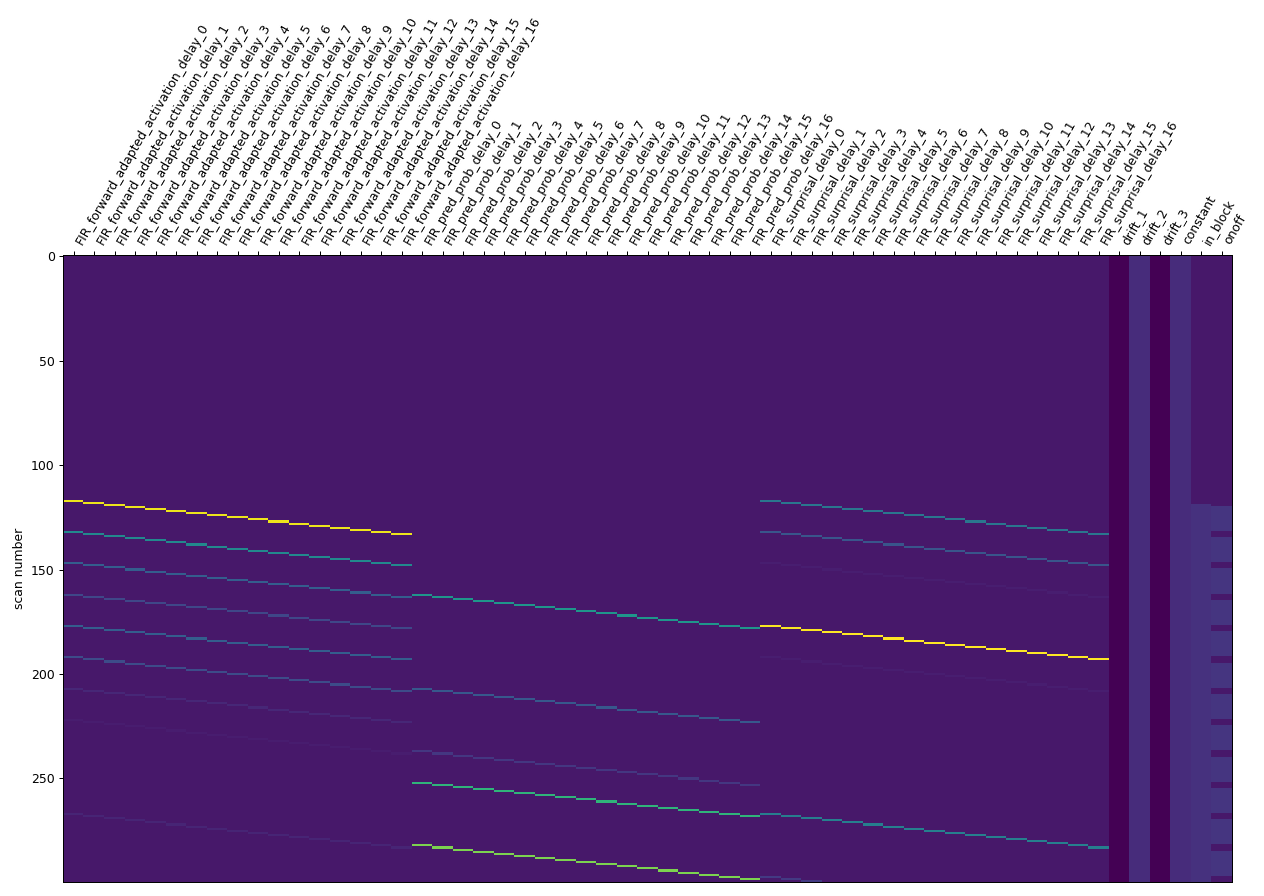

<AxesSubplot:label='conditions', ylabel='scan number'>

In [179]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(X_mat.head(300))

In [180]:
# X_mat['onoff'] = df['onoff']

plot_design_matrix(X_mat[['FIR_onoff_delay_0', 'FIR_onoff_delay_1', 'FIR_onoff_delay_2',
       'FIR_onoff_delay_3', 'FIR_onoff_delay_4', 'FIR_onoff_delay_5',
       'FIR_onoff_delay_6', 'FIR_onoff_delay_7', 'FIR_onoff_delay_8',
       'FIR_onoff_delay_9', 'FIR_onoff_delay_10', 'FIR_onoff_delay_11',
       'FIR_onoff_delay_12', 'FIR_onoff_delay_13', 'FIR_onoff_delay_14',
       'FIR_onoff_delay_15',
       'in_block']].iloc[100:150])

KeyError: "['FIR_onoff_delay_0', 'FIR_onoff_delay_1', 'FIR_onoff_delay_2', 'FIR_onoff_delay_3', 'FIR_onoff_delay_4', 'FIR_onoff_delay_5', 'FIR_onoff_delay_6', 'FIR_onoff_delay_7', 'FIR_onoff_delay_8', 'FIR_onoff_delay_9', 'FIR_onoff_delay_10', 'FIR_onoff_delay_11', 'FIR_onoff_delay_12', 'FIR_onoff_delay_13', 'FIR_onoff_delay_14', 'FIR_onoff_delay_15'] not in index"

## do the actual regressions

In [ ]:
# select and oder data based on channel names - convert to numpy
raw_data = df[ ft_meeg_data['ch_names'] ].to_numpy().T


In [ ]:
def z_score_blocks(df, ch_names, blk_nm='BLOCK'):
    """zscore per block and return adjusted dataframe
    input dataframe: with channels and block identifier
    ch_names: name of channels to zscore (i.e. data channels)
    blk_nm: name of catagory to zscore over
    returns adjusted dataframe"""

    # make a copy of our original dataframe
    df_zs = df.copy(deep=True)

    # loop over blocks
    for blk in df_zs[blk_nm].unique():

        # z-score current block and save in correct location
        df_zs.loc[df_zs[blk_nm] == blk, ch_names] = z_score(df_zs.loc[df_zs[blk_nm] == blk, ch_names])
    return df_zs
    

def z_score(df):
    """zscore multiple columns at once"""
    return ((df - df.mean())/df.std(ddof=0))


In [ ]:
## TESTING WITH SKLEARN

from sklearn.linear_model import LinearRegression, Ridge, Lasso

def simplified_multioutput_regression(X_mat, data):

    # Initialize the linear regression model
    model = LinearRegression()
#     model = Ridge(alpha=0.01, solver="sparse_cg", fit_intercept=True, max_iter=1000, tol=0.001)
    
    # Fit the model
    model.fit(X_mat, data)

    # Predict to compute R-squared for each channel
    y_pred = model.predict(X_mat)
    rsquared = 1 - ((data - y_pred) ** 2).sum(axis=0) / ((data - data.mean(axis=0)) ** 2).sum(axis=0)

    # Compute correlation coefficient for each channel
    correlations = [np.corrcoef(data[:, i], y_pred[:, i])[0, 1] for i in range(data.shape[1])]

    results = {
        "coefficients": model.coef_,
        "intercepts": model.intercept_,
        "rsquared": rsquared,
        "correlations": correlations
    }
    
    return results



In [ ]:
results = simplified_multioutput_regression(X_mat, raw['data'][0].T)
results['coefficients'].shape

In [ ]:
# channel names (in input of function)
df_zs = z_score_blocks(df, ft_meeg_data['ch_names'])

# select and oder data based on channel names - convert to numpy
y = df_zs[ ft_meeg_data['ch_names'] ].to_numpy()

# run the regression
results = simplified_multioutput_regression(X_mat, y)
results['coefficients'].shape

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(results['correlations'])

In [181]:
# ## PLOTTING THE TRF BY COEFS

# coefs = results['coefficients'].mean(axis=0)


# # Extract base names of the regressors
# base_names = ['FIR_forward_adapation', 'FIR_forward_adapted_activation', 'FIR_frequencies_oct', 'FIR_onoff', 'FIR_pred_prob', 'FIR_surprisal']
# # base_names = ['FIR_frequencies_oct', 'FIR_pred_prob', 'FIR_surprisal']


# # Create a dictionary to store coefficients for each base name
# coef_dict = {}

# # For each base name, extract coefficients for each delay
# for base in base_names:
#     coef_dict[base] = [coefs[X_mat.columns.get_loc(f"{base}_delay_{i}")] for i in range(19)]

# # Plotting
# plt.figure(figsize=(12, 6))
# for base, coef_vals in coef_dict.items():
#     plt.plot([i*t_step for i in range(19)], coef_vals, label=base)

# plt.xlabel('Delay (ms)')
# plt.ylabel('Coefficient Value')
# plt.title('Regression Coefficients for Different Delays')
# plt.legend()
# plt.grid(True)
# plt.show()



In [182]:
# import matplotlib.pyplot as plt

# # Assuming you have defined results and X_mat already

# # Extract base names of the regressors
# base_names = ['FIR_frequencies_oct', 'FIR_onoff', 'FIR_pred_prob', 'FIR_surprisal']
# smooth_steps = 4  # You can adjust this value as needed

# # For each base name
# for base in base_names:
#     plt.figure(figsize=(12, 6))
    
#     # For each set of coefficients in results['coefficients']
#     for coef_set in results['coefficients']:
#         coef_vals = [coef_set[X_mat.columns.get_loc(f"{base}_delay_{i}")] for i in range(19)]
# #         coef_vals = simple_moving_average(coef_vals, smooth_steps)
        
# #         # Subtract the first value from each coefficient value
# #         coef_vals = [val - np.mean(coef_vals[0:10]) for val in coef_vals]
        
# #         coef_vals = align_polarity(coef_vals)
#         x_range = np.arange(t_start, t_stop+t_step, t_step)
#         plt.plot(x_range, coef_vals, alpha=0.5)  # Use alpha for better visualization if lines overlap
    
#     plt.xlabel('Delay (ms)')
#     plt.ylabel('Coefficient Value')
#     plt.title(f'Regression Coefficients for {base} across Different Delays')
#     plt.grid(True)
#     plt.show()


In [183]:
## cleanup something to make plots easier readable

def align_polarity(coef_vals):
    """Align the polarity of the coefficients based on the sign of the maximum absolute value coefficient."""
    return np.array([coef * (1 if max(coef, key=abs) >= 0 else -1) for coef in coef_vals])

import numpy as np

def simple_moving_average(data, window_size):
    """
    Computes the simple moving average of the given data.
    
    Parameters:
    - data: The time series data.
    - window_size: The size of the moving average window.
    
    Returns:
    - A list containing the smoothed data.
    """
    if window_size <= 1:
        return data
    
    smoothed_data = []
    for i in range(len(data)):
        start_idx = max(0, i - window_size + 1)
        end_idx = i + 1
        smoothed_data.append(np.mean(data[start_idx:end_idx]))
        
    return smoothed_data


def demean_simple(data, timestamps):
    """demean the data based on where timestamps threshold is before onset"""

    # get indexes of 'baseline'
    before_onset = np.where(timestamps < 0.01)[0]

    # get means and demean data
    mz = np.mean(data[:, before_onset], axis=1)
    data = data - mz[:, None]
    
    return data

In [184]:
import numpy as np

def simple_moving_average_2d(data, window_size):
    """
    Computes the simple moving average of the given 2D data.
    
    Parameters:
    - data: The 2D time series data where the first dimension is the number of sensors, 
      and the second dimension is the time data.
    - window_size: The size of the moving average window.
    
    Returns:
    - A 2D list containing the smoothed data for each sensor.
    """
    num_sensors, num_samples = data.shape
    if window_size <= 1:
        return data
    
    smoothed_data = np.zeros((num_sensors, num_samples))
    
    for sensor_idx in range(num_sensors):
        for time_idx in range(num_samples):
            start_idx = max(0, time_idx - window_size + 1)
            end_idx = time_idx + 1
            smoothed_data[sensor_idx, time_idx] = np.mean(data[sensor_idx, start_idx:end_idx])
        
    return smoothed_data


11520 events found
Event IDs: [1]
Not setting metadata
11520 matching events found
Removing 10240 compensators from info because not all compensation channels were picked.
Setting baseline interval to [-0.05, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11520 events and 17 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<IPython.core.display.Javascript object>


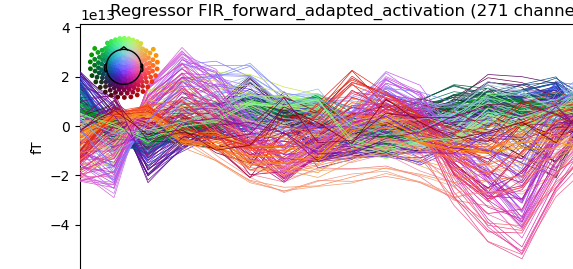

<IPython.core.display.Javascript object>


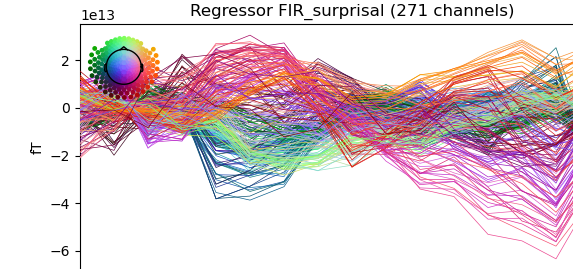

<IPython.core.display.Javascript object>


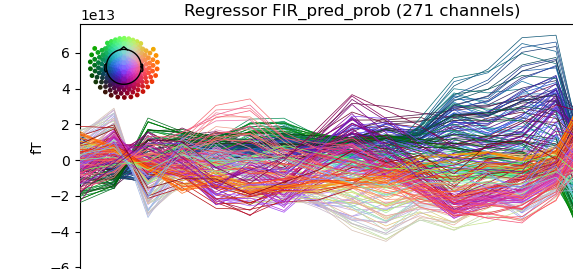

In [185]:
import numpy as np
import mne

import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt




## DO THE REGRESSION

# channel names (in input of function)
df_zs = z_score_blocks(df, ft_meeg_data['ch_names'])

# select and oder data based on channel names - convert to numpy
y = df_zs[ ft_meeg_data['ch_names'] ].to_numpy()

# run the regression
results = simplified_multioutput_regression(X_mat, y)
results['coefficients'].shape



## PLOT THE REGRESSION



# Extract base names of the regressors
base_names = cois
# base_names = ['FIR_frequencies_oct', 'FIR_onoff', 'FIR_pred_prob', 'FIR_surprisal']

# Find events / create epochs
events = mne.find_events(raw, stim_channel='FIR_onoff')
epochs = mne.Epochs(raw, events, tmin=t_start, tmax=t_stop, preload=True)


## PUTT ALL COEFFICIENTS RESULTS INTO ONE DATAFRAME ##

# Convert coefficients to DataFrame
df_coefs = pd.DataFrame(results['coefficients'], columns=X_mat.columns)

# Use list comprehension to get 2D arrays for each base and stack them to get a 3D array
final_coefficients = np.stack([
    df_coefs.filter(like=f"{base}_delay_").to_numpy() for base in base_names
    ])


## PUT INTO EVOLKED DATADRAME

# Get the times array from epochs
times = np.linspace(epochs.tmin, epochs.tmax, final_coefficients.shape[2])

# select only sensor data
epochs.pick_types(meg=True, stim=False)

# Convert the numpy array to an Evoked object for each regressor
evokeds = []
for i in range(final_coefficients.shape[0]):
    # Average across epochs (axis 2) for each regressor
    data = final_coefficients[i]
    
    # somewhat clean up the data a bit
    timestamps = epochs.times
    data = demean_simple(data, timestamps)
#     data = simple_moving_average_2d(data, 2)
#     data = align_polarity(data)
    
    
    # append evoked results
    evoked = mne.EvokedArray(data, epochs.info, tmin=epochs.tmin)
    
#     # do axial to planar transformation
#     evoked = evoked.as_type('mag')
    
    # save in dict
    evokeds.append(evoked)

# Now you can plot the evoked objects for each regressor
for idx, evoked in enumerate(evokeds, 1):
    evoked.plot(titles=f'Regressor {base_names[idx-1]}')


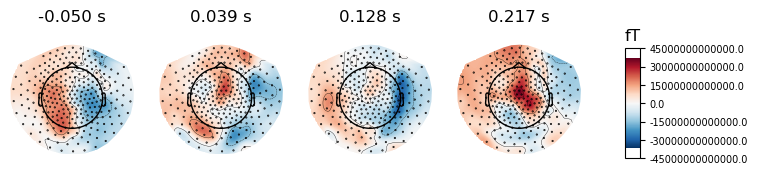

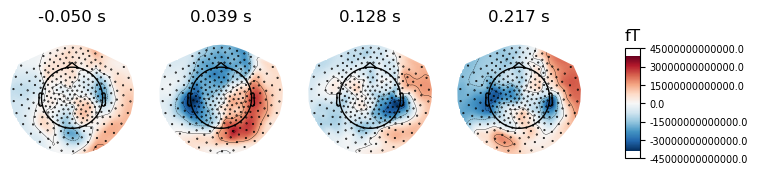

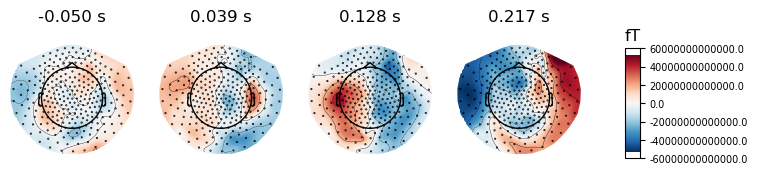

In [186]:
%matplotlib inline

# Now you can plot the evoked objects for each regressor
for idx, evoked in enumerate(evokeds, 1):
    
    # go from grad + mag to mag and plot original mag
    fig = evoked.plot_topomap(ch_type="mag")
    fig.suptitle(f'Regressor {base_names[idx-1]}')

<IPython.core.display.Javascript object>


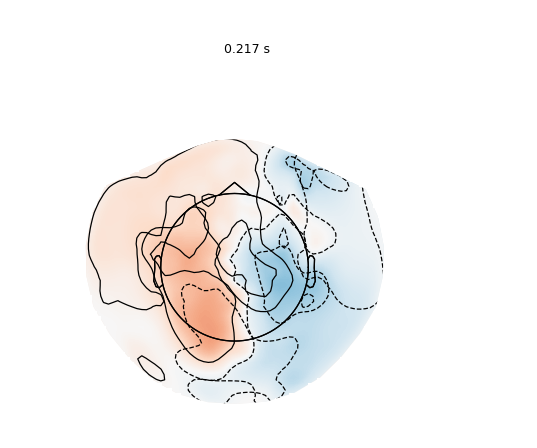

<IPython.core.display.Javascript object>


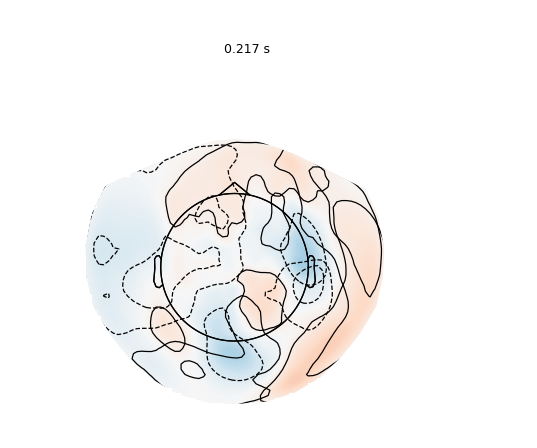

<IPython.core.display.Javascript object>


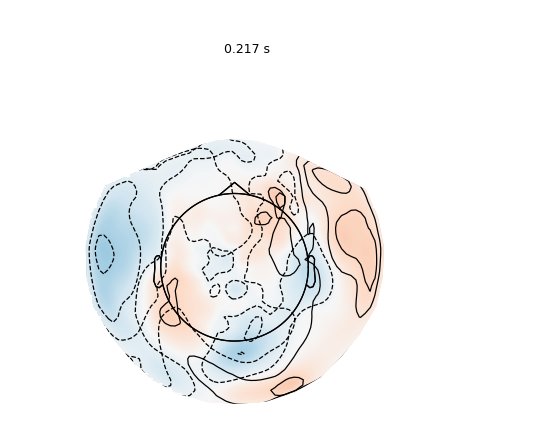

In [189]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

timestamps = evoked.times

# Now you can plot the evoked objects for each regressor
for idx, evoked in enumerate(evokeds, 1):
    fig, anim = evoked.animate_topomap(times=timestamps, ch_type="mag", frame_rate=2, blit=False)
    fig.suptitle(f'Regressor {base_names[idx-1]}')
    
plt.show()

In [188]:
## save images

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Your other imports and variables (e.g., t_start, t_stop, t_step) should be defined here

n_times = int(np.round((t_stop - t_start) / t_step))  # calculate the number of timesteps
timestamps = np.linspace(t_start, t_stop, num=n_times)

# Assuming 'evokeds' is a list of MNE-Python's Evoked objects
for idx, evoked in enumerate(evokeds, 1):
    fig, anim = evoked.animate_topomap(times=timestamps, ch_type="mag", frame_rate=2, blit=False)
    fig.suptitle(f'Regressor {base_names[idx-1]}')
    
    # Save the animation as a GIF
#     gif_filename = f'Regressor_{base_names[idx-1]}.gif'
#     anim.save(gif_filename, writer='imagemagick', fps=2)


ValueError: All times must be inside the evoked time series.

In [ ]:
# %matplotlib inline

# Now you can plot the evoked objects for each regressor
for idx, evoked in enumerate(evokeds, 1):
    
    evoked_p = magplanar_proxy(evoked)
    evoked_p.plot(titles=f'Regressor {base_names[idx-1]}')
    
    

In [ ]:
import mne

# Assume 'evoked' is your Evoked data loaded from a fif file:
# evoked = mne.read_evokeds('your-file.fif', condition='Left Auditory')

# MNE does not calculate planar gradients directly, but you can manipulate
# the gradiometer data manually. The gradiometer pairs need to be known.

# Here is an example of how you might combine gradiometer pairs manually:
# This assumes that you have a Neuromag system where the pairs are interleaved.
# Please adjust the indices according to your MEG system's channel order.


def magplanar_proxy(evoked):
    """calculate a proxy of the gradiometers with mne,
    not perfect but good for intuation - use in fieldtrip just raw data"""

    grad_pairs = zip(evoked.ch_names[::2], evoked.ch_names[1::2])

    combined_grad = evoked.copy()
    for ch1, ch2 in grad_pairs:
        ch1_idx = combined_grad.ch_names.index(ch1)
        ch2_idx = combined_grad.ch_names.index(ch2)
        combined_grad.data[ch1_idx, :] = np.sqrt(
            evoked.data[ch1_idx, :] ** 2 + evoked.data[ch2_idx, :] ** 2
        )

    # Now 'combined_grad' contains the root sum square of the gradiometer pairs.
    # You may want to drop the second gradiometers as they have been combined into the first:
    drop_ch_names = [ch for i, ch in enumerate(evoked.ch_names) if i % 2 != 0]
    combined_grad.drop_channels(drop_ch_names)

    return(combined_grad)

<IPython.core.display.Javascript object>


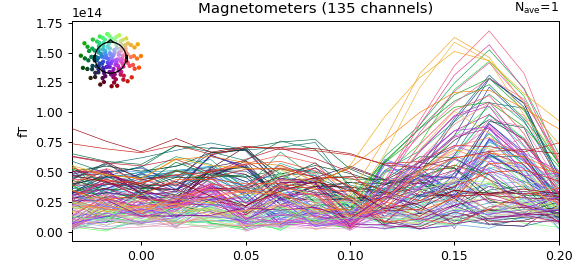

<IPython.core.display.Javascript object>


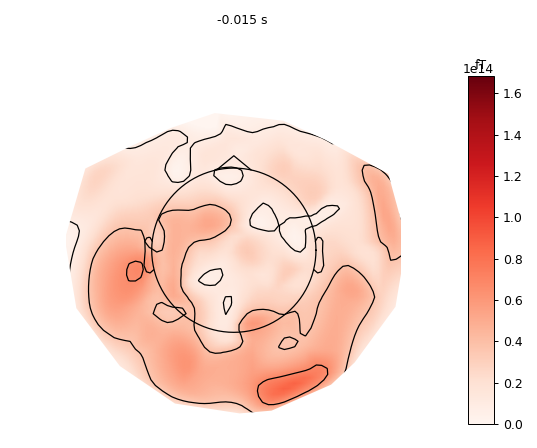

In [483]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

combined_grad.plot()

n_times = int(np.round((t_stop - t_start) / t_step))  # calculate the number of timesteps
timestamps = np.linspace(t_start, t_stop, num=n_times)

# Now you can plot the evoked objects for each regressor
fig, anim = combined_grad.animate_topomap(times=timestamps, ch_type="mag", frame_rate=2, blit=False)
    
plt.show()

In [472]:
evoked.ch_names

['MLC11-4304',
 'MLC12-4304',
 'MLC13-4304',
 'MLC14-4304',
 'MLC15-4304',
 'MLC16-4304',
 'MLC17-4304',
 'MLC21-4304',
 'MLC22-4304',
 'MLC23-4304',
 'MLC24-4304',
 'MLC25-4304',
 'MLC31-4304',
 'MLC32-4304',
 'MLC41-4304',
 'MLC42-4304',
 'MLC51-4304',
 'MLC52-4304',
 'MLC53-4304',
 'MLC54-4304',
 'MLC55-4304',
 'MLC61-4304',
 'MLC62-4304',
 'MLC63-4304',
 'MLF11-4304',
 'MLF12-4304',
 'MLF13-4304',
 'MLF14-4304',
 'MLF21-4304',
 'MLF22-4304',
 'MLF23-4304',
 'MLF24-4304',
 'MLF25-4304',
 'MLF31-4304',
 'MLF32-4304',
 'MLF33-4304',
 'MLF34-4304',
 'MLF35-4304',
 'MLF41-4304',
 'MLF42-4304',
 'MLF43-4304',
 'MLF44-4304',
 'MLF45-4304',
 'MLF46-4304',
 'MLF51-4304',
 'MLF52-4304',
 'MLF53-4304',
 'MLF54-4304',
 'MLF55-4304',
 'MLF56-4304',
 'MLF61-4304',
 'MLF62-4304',
 'MLF63-4304',
 'MLF64-4304',
 'MLF65-4304',
 'MLF66-4304',
 'MLF67-4304',
 'MLO11-4304',
 'MLO12-4304',
 'MLO13-4304',
 'MLO14-4304',
 'MLO21-4304',
 'MLO22-4304',
 'MLO23-4304',
 'MLO24-4304',
 'MLO31-4304',
 'MLO32-43

In [480]:
import numpy as np
import mne

# Assume 'evoked' is your Evoked data loaded from a fif file:
# evoked = mne.read_evokeds('your-file.fif', condition='Left Auditory')

# Read the channel adjacency information
neighbors, _ = mne.channels.read_ch_adjacency('ctf275')

# Copy the evoked data to manipulate it
combined_grad = evoked.copy()

# Find the gradiometer pairs using the adjacency information
for idx, ch_name in enumerate(evoked.ch_names):
    # find the corresponding pair
    neighbor_indices = neighbors[idx].nonzero()[0]
    for neighbor_idx in neighbor_indices:
        if evoked.ch_names[neighbor_idx] in combined_grad.ch_names:
            # Combine the gradiometer measurements
            combined_grad.data[idx, :] = np.sqrt(
                evoked.data[idx, :] ** 2 + evoked.data[neighbor_idx, :] ** 2
            )
            # Remove the second gradiometer as it has been combined
            combined_grad.drop_channels([evoked.ch_names[neighbor_idx]])
            break  # assuming only one neighbor is the pair

# Now 'combined_grad' contains the root sum square of the gradiometer pairs


In [62]:
# Calculate the time differences between consecutive events
event_durations = np.diff(events[:, 0])

# Get the maximum event duration in seconds
max_duration = event_durations.max() / raw.info['sfreq']

# Find events
events = mne.find_events(raw, stim_channel='FIR_BLOCK', initial_event=True)

# Create epochs
epochs = mne.Epochs(raw, events, tmin=-0.0, tmax=max_duration+2, preload=True, baseline=None)

24 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Not setting metadata
24 matching events found
Removing 10240 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 1138 original time points ...
0 bad epochs dropped


In [286]:
## ADD FULL DESIGN MATRIX
regs =  X_mat.columns

for evnt in regs:
    raw = add_event_from_df(raw, X_mat, evnt)

Creating RawArray with float64 data, n_channels=1, n_times=179909
    Range : 0 ... 179908 =      0.000 ...  2998.467 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179909
    Range : 0 ... 179908 =      0.000 ...  2998.467 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179909
    Range : 0 ... 179908 =      0.000 ...  2998.467 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179909
    Range : 0 ... 179908 =      0.000 ...  2998.467 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179909
    Range : 0 ... 179908 =      0.000 ...  2998.467 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179909
    Range : 0 ... 179908 =      0.000 ...  2998.467 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179909
    Range : 0 ... 179908 =      0.000 ...  2998.467 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179909
    Range : 0 ... 179908

MemoryError: 

In [ ]:
## TESTING WITH MNE

from mne.stats import linear_regression

## ADD FULL DESIGN MATRIX
regs =  X_mat.columns

for evnt in regs:
    raw = add_event_from_df(raw, X_mat, evnt)
    
    
# Calculate the time differences between consecutive events
event_durations = np.diff(events[:, 0])
# Get the maximum event duration in seconds
max_duration = event_durations.max() / raw.info['sfreq']

# Find events
events = mne.find_events(raw, stim_channel='FIR_BLOCK', initial_event=True)
# Create epochs
epochs = mne.Epochs(raw, events, tmin=-0.0, tmax=max_duration+2, preload=True, baseline=None)
    
    
# Get the data for the channelS
regs_data = raw.copy().pick_channels(regs).get_data()
    
# Assuming data is your MEG data and X_mat is your design matrix
results = linear_regression(epochs, regs_data, names=regs)


## HIER GEBLEVEN: DOING THE REGRESSIONS AGAIN BUT THIS TIME WITHIN THE MNE FRAMEWORK
## WHICH SHOULD WORK LIKE THIS AS WE ARE DOING IN IN LONG EPOCHS THAT ARE THE ENTIRE BLOCKS
## HOWEVER MAYBE JUST USE SKLEARN - DONT KNOW - ANYWAY THAT ISNT DONE EITHER


In [ ]:
# 2. Plot Results
base_names = ['FIR_forward_adapation', 'FIR_forward_adapted_activation', 'FIR_frequencies_oct', 'FIR_onoff', 'FIR_pred_prob', 'FIR_surprisal']

plt.figure(figsize=(12, 6))
for base in base_names:
    betas = [results[f"{base}_delay_{i}"].beta for i in range(19)]
    plt.plot([i*16 for i in range(19)], betas, label=base)

plt.xlabel('Delay (ms)')
plt.ylabel('Beta Coefficient Value')
plt.title('Regression Coefficients for Different Delays')
plt.legend()
plt.grid(True)
plt.show()


In [178]:
for i in X_mat.columns:
    print(i)

FIR_forward_adapation_delay_0
FIR_forward_adapation_delay_1
FIR_forward_adapation_delay_2
FIR_forward_adapation_delay_3
FIR_forward_adapation_delay_4
FIR_forward_adapation_delay_5
FIR_forward_adapation_delay_6
FIR_forward_adapation_delay_7
FIR_forward_adapation_delay_8
FIR_forward_adapation_delay_9
FIR_forward_adapation_delay_10
FIR_forward_adapation_delay_11
FIR_forward_adapation_delay_12
FIR_forward_adapation_delay_13
FIR_forward_adapation_delay_14
FIR_forward_adapation_delay_15
FIR_forward_adapation_delay_16
FIR_forward_adapation_delay_17
FIR_forward_adapation_delay_18
FIR_forward_adapted_activation_delay_0
FIR_forward_adapted_activation_delay_1
FIR_forward_adapted_activation_delay_2
FIR_forward_adapted_activation_delay_3
FIR_forward_adapted_activation_delay_4
FIR_forward_adapted_activation_delay_5
FIR_forward_adapted_activation_delay_6
FIR_forward_adapted_activation_delay_7
FIR_forward_adapted_activation_delay_8
FIR_forward_adapted_activation_delay_9
FIR_forward_adapted_activation_

In [168]:
raw['data'][0]

array([[ 1.91655312e-14,  1.60386207e-14,  3.80508541e-14, ...,
        -1.67012369e-13,  1.02199791e-13,  1.16014628e-13],
       [ 8.30896090e-14,  7.84066520e-14,  5.40819634e-14, ...,
        -1.24618736e-13,  1.95459349e-13,  1.09532801e-13],
       [ 3.08997526e-14,  3.70187745e-14, -3.92787787e-14, ...,
        -1.85670645e-13,  1.57700624e-13,  1.10473576e-13],
       ...,
       [ 6.63197088e-14,  1.57777144e-13,  9.36160469e-14, ...,
         3.53168502e-14, -3.03213675e-14, -5.59967078e-14],
       [ 7.93175251e-14,  1.83709242e-13,  1.68701971e-13, ...,
        -2.93665130e-14, -9.67515153e-14,  9.40688944e-14],
       [ 7.93537139e-14,  1.03629295e-13,  1.13744964e-13, ...,
         4.52964493e-13,  1.40962511e-13,  1.56378832e-13]])

In [118]:
len(ft_meeg_data['ch_names'])

270

In [145]:
speech

array([-0.00354461,  0.00354461, -0.00354682, ...,  0.00096403,
       -0.00096325,  0.00096273])

Creating RawArray with float64 data, n_channels=270, n_times=89954
Current compensation grade : 0
    Range : 0 ... 89953 =      0.000 ...  1499.217 secs
Ready.


[Text(0.5, 1.0, 'Sample activity'), Text(0.5, 0, 'Time (s)')]

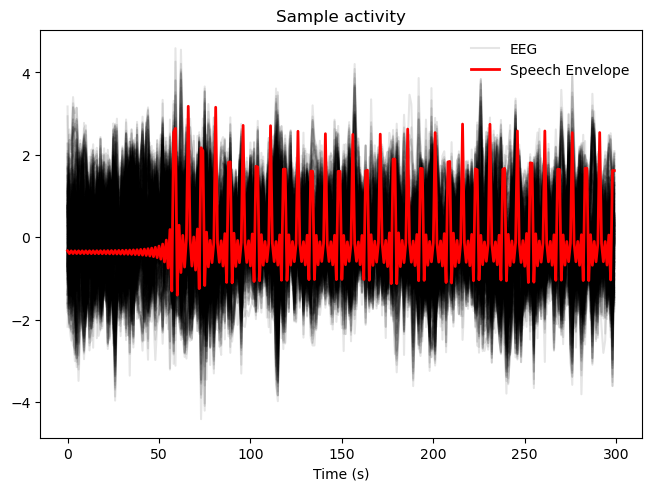

In [147]:
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale

import mne
from mne.decoding import ReceptiveField

decim = 2

speech = X_mat.T.to_numpy()
speech = mne.filter.resample(speech, down=decim, npad="auto")
raw2 = raw['data'][0]
raw2 = mne.filter.resample(raw2, down=decim, npad="auto")

# Read in channel positions and create our MNE objects from the raw data
raw2 = mne.io.RawArray(raw2, raw.info)
n_channels = len(raw2.ch_names)

# Plot a sample of brain and stimulus activity
fig, ax = plt.subplots(layout="constrained")
lns = ax.plot(scale(raw2[:, :300][0].T), color="k", alpha=0.1)
ln1 = ax.plot(scale(speech[0, :300]), color="r", lw=2)
ax.legend([lns[0], ln1[0]], ["EEG", "Speech Envelope"], frameon=False)
ax.set(title="Sample activity", xlabel="Time (s)")


In [114]:
raw.info['ch_names']

['MLC11-4304',
 'MLC12-4304',
 'MLC13-4304',
 'MLC14-4304',
 'MLC15-4304',
 'MLC16-4304',
 'MLC17-4304',
 'MLC21-4304',
 'MLC22-4304',
 'MLC23-4304',
 'MLC24-4304',
 'MLC25-4304',
 'MLC31-4304',
 'MLC32-4304',
 'MLC41-4304',
 'MLC42-4304',
 'MLC51-4304',
 'MLC52-4304',
 'MLC53-4304',
 'MLC54-4304',
 'MLC55-4304',
 'MLC61-4304',
 'MLC62-4304',
 'MLC63-4304',
 'MLF11-4304',
 'MLF12-4304',
 'MLF13-4304',
 'MLF14-4304',
 'MLF21-4304',
 'MLF22-4304',
 'MLF23-4304',
 'MLF24-4304',
 'MLF25-4304',
 'MLF31-4304',
 'MLF32-4304',
 'MLF33-4304',
 'MLF34-4304',
 'MLF35-4304',
 'MLF41-4304',
 'MLF42-4304',
 'MLF43-4304',
 'MLF44-4304',
 'MLF45-4304',
 'MLF46-4304',
 'MLF51-4304',
 'MLF52-4304',
 'MLF53-4304',
 'MLF54-4304',
 'MLF55-4304',
 'MLF56-4304',
 'MLF61-4304',
 'MLF62-4304',
 'MLF63-4304',
 'MLF64-4304',
 'MLF65-4304',
 'MLF66-4304',
 'MLF67-4304',
 'MLO11-4304',
 'MLO12-4304',
 'MLO13-4304',
 'MLO14-4304',
 'MLO21-4304',
 'MLO22-4304',
 'MLO23-4304',
 'MLO24-4304',
 'MLO31-4304',
 'MLO32-43

In [99]:
data.columns

Index(['MLC11', 'MLC12', 'MLC13', 'MLC14', 'MLC15', 'MLC16', 'MLC17', 'MLC21',
       'MLC22', 'MLC23',
       ...
       'MZF03', 'MZO01', 'MZO02', 'MZO03', 'MZP01', 'MLP35', 'MRT11', 'MRT22',
       'MRT31', 'MRT41'],
      dtype='object', length=275)

In [71]:
t_start = -0.05

indices = df.loc[df[coi] > 0, clk_label].apply(lambda x: (df[clk_label] - (x + t_start)).abs().idxmin())


indices


## this works to get indeces

119          116
134          131
149          146
164          161
179          176
           ...  
179653    179650
179668    179665
179683    179680
179698    179695
179713    179710
Name: TIMESTAMP, Length: 11520, dtype: int64

In [458]:
df.iloc[indices]['TIMESTAMP']

116        8461.045417
131        8461.295417
146        8461.545417
161        8461.795417
176        8462.045417
              ...     
179650    11786.345417
179665    11786.595417
179680    11786.845417
179695    11787.095417
179710    11787.345417
Name: TIMESTAMP, Length: 11520, dtype: float64

In [459]:
df.iloc[119]['TIMESTAMP']

8461.09541666667

In [445]:
# get tr, number of scans, and corresponding frame times
tr = np.round(df['TIMESTAMP'].diff()[1], 4)
n_scans = len(df['TIMESTAMP'])
# frame_times = np.arange(n_scans) * tr
frame_times = df['TIMESTAMP'].round(4)

# create event dictionary and corresponding dataframe
event_dict = {
            "trial_type": conditions,
            "onset": onsets,
            "duration": duration,
            "modulation": modulation,
             }
event_df = pd.DataFrame(event_dict)

# create the fir model
hrf_model = "FIR"
X_mat = make_first_level_design_matrix(
    frame_times,
    event_df,
    hrf_model="fir",
    drift_model="polynomial",
    drift_order=3,
    fir_delays=np.arange(0, n_times),
)

A 'modulation' column was found in the given events data and is used.


In [169]:
len(frame_times)

179909

In [171]:
len(df['TIMESTAMP'])

179909

In [172]:
import numpy as np

tr = 1.0  # repetition time is 1 second
n_scans = 128  # the acquisition comprises 128 scans
frame_times = np.arange(n_scans) * tr  # here are the corresponding frame times


# these are the types of the different trials
conditions = ["c0", "c0", "c0", "c1", "c1", "c1", "c3", "c3", "c3"]
duration = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# these are the corresponding onset times
onsets = [30.0, 70.0, 100.0, 10.0, 30.0, 90.0, 30.0, 40.0, 60.0]

import pandas as pd

events = pd.DataFrame(
    {"trial_type": conditions, "onset": onsets, "duration": duration}
)
hrf_model = "FIR"
X3 = make_first_level_design_matrix(
    frame_times,
    events,
    hrf_model="fir",
    drift_model="polynomial",
    drift_order=3,
    fir_delays=np.arange(1, 6),
)

/project/3018063.01/repos/conda_env/predlis/lib/python3.8/site-packages/nilearn/glm/first_level/hemodynamic_models.py:410: UserWarning: Some stimulus onsets are earlier than 8435.112083333337 in the experiment and are thus not considered in the model.
  warnings.warn(
/project/3018063.01/repos/conda_env/predlis/lib/python3.8/site-packages/nilearn/glm/_utils.py:317: RuntimeWarning: divide by zero encountered in double_scalars
  cond = smax / smin
/project/3018063.01/repos/conda_env/predlis/lib/python3.8/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


/scratch/jorvhar/50241822.dccn-l029.dccn.nl/ipykernel_18449/3843896732.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


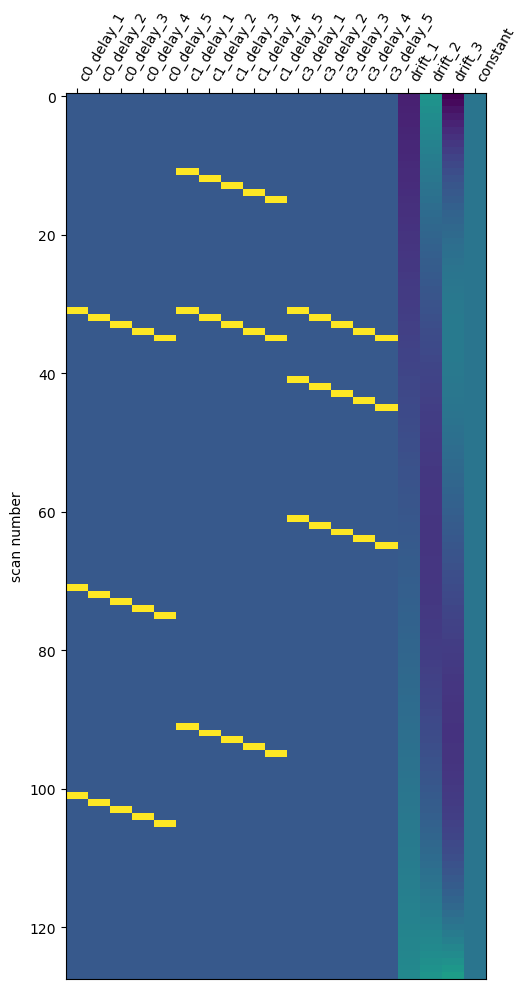

In [166]:
from nilearn.plotting import plot_design_matrix


plot_design_matrix(X3)
fig.show()



In [167]:
df['TIMESTAMP']

0          8459.112083
1          8459.128750
2          8459.145417
3          8459.162083
4          8459.178750
              ...     
179904    11790.578750
179905    11790.595417
179906    11790.612083
179907    11790.628750
179908    11790.645417
Name: TIMESTAMP, Length: 179909, dtype: float64

In [398]:
df.columns

Index(['MLC11', 'MLC12', 'MLC13', 'MLC14', 'MLC15', 'MLC16', 'MLC17', 'MLC21',
       'MLC22', 'MLC23',
       ...
       'FIR_forward_adapation', 'OFFSET_FIR_forward_adapation',
       'FIR_forward_adapted_activation',
       'OFFSET_FIR_forward_adapted_activation', 'FIR_onoff',
       'OFFSET_FIR_onoff', 'FIR_BLOCK', 'OFFSET_FIR_BLOCK', 'FIR_segment_all',
       'OFFSET_FIR_segment_all'],
      dtype='object', length=303)

In [ ]:
## now we get the actication and adapted activation based on the 2400xstims we got out,
## find index per row 



In [61]:
# create a list of all indexes
all_idxs = np.arange(len(pref_range) * len(sharp_range))

# get list of 
tunprefs, tunsharps = longtrace_adaptation.md_get_tuning(all_idxs, pref_range, sharp_range)

In [78]:
# take one tw for now
what_tw = sharp_range[5]





In [80]:
tunsharps == what_tw

array([False, False, False, ..., False, False, False])

In [ ]:
# get dictionaries by naming
grid_dict = {f'{:.3f}_{:.3f}'.format(tunprefs[idx], tunsharps[idx]): 
              activations[idx, :] for idx in all_idxs}

In [66]:
activations.shape

(2400, 11520)

In [68]:
a = np.array([[1 , 2, 3, 4, 5],
             [1.2, 2.2, 2.4, 2,5],
             [2, 4, 5, 6, 7]])

In [70]:
a.shape

(3, 5)

In [71]:
import numpy as np

activations = np.array([[1, 2, 3, 4, 5],
                        [1.2, 2.2, 2.4, 2.5, 0],
                        [2, 4, 5, 6, 7]])
idx_array = np.array([0, 0, 2, 1, 2])

# Use idx_array to select rows from activations
result = activations[idx_array, np.arange(len(idx_array))]

print(result)

[1.  2.  5.  2.5 7. ]


In [56]:
def stims_add_adaptation(stim_df, pref_range, sharp_range, activations, adaptations, adapted_activations):
    """given a adaptation, activation and adaptated activation matrix, update the dataframe"""
    # create a list of all indexes
    all_idxs = np.arange(len(pref_range) * len(sharp_range))

    # get list of 
    tunprefs, tunsharps = longtrace_adaptation.md_get_tuning(all_idxs, pref_range, sharp_range)

    # get dictionaries by naming
    acti_names = {'raw_acti_{:.3f}_{:.3f}'.format(tunprefs[idx], tunsharps[idx]): 
                  activations[idx, :] for idx in all_idxs}
    adapt_names = {'raw_adapt_{:.3f}_{:.3f}'.format(tunprefs[idx], tunsharps[idx]): 
                   adaptations[idx, :] for idx in all_idxs}
    adapt_acti_names = {'adapt_activ_{:.3f}_{:.3f}'.format(tunprefs[idx], tunsharps[idx]): 
                        adapted_activations[idx, :] for idx in all_idxs}

    # combine dictionaries
    acti_names.update(adapt_names)
    acti_names.update(adapt_acti_names)
    
    # append adapation and activation to pd dataframe
    stim_df = pd.concat([stim_df, pd.DataFrame(acti_names)], axis=1)
    return(stim_df)

In [58]:
stim_df = stims_add_adaptation(df_beh, 
                                       pref_range, 
                                       sharp_range, 
                                       activations, 
                                       1-adaptations,       # take 1-adaptation to make filling with 0s possible
                                       adapted_activations)

<AxesSubplot:>

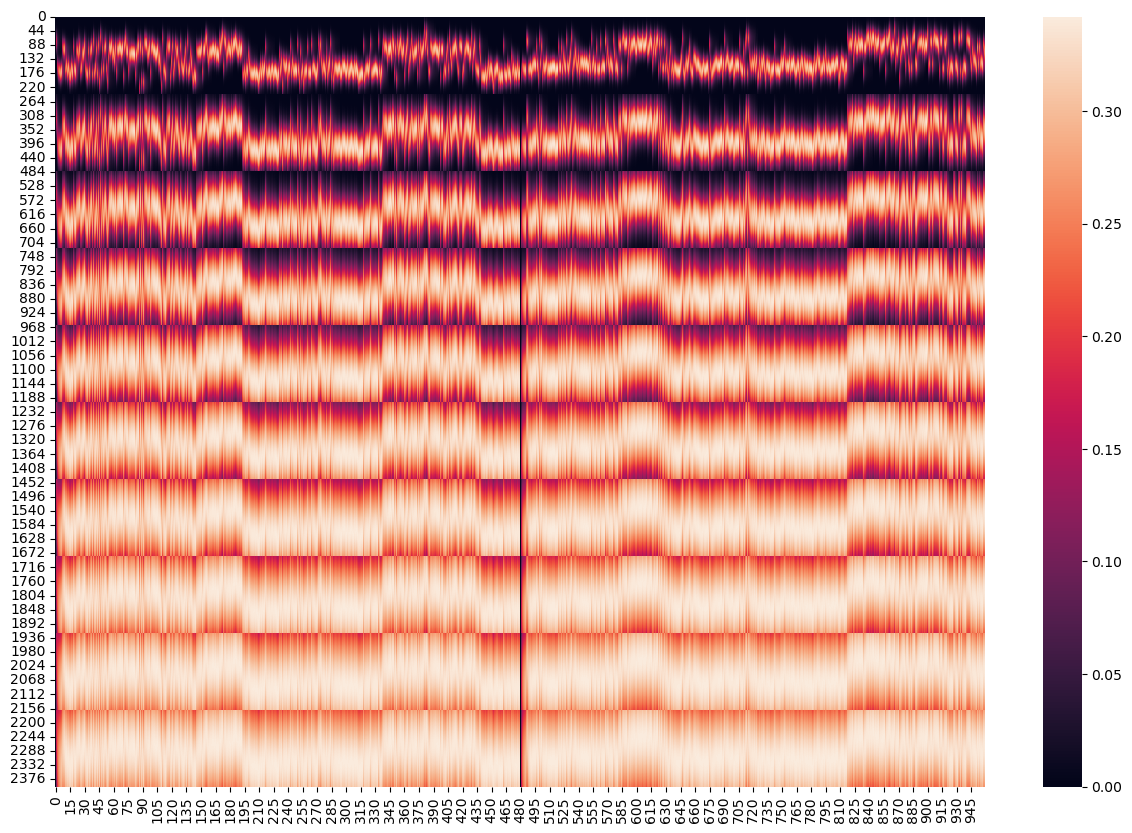

In [60]:
# quick senity check
run = 5
activs = stim_df[stim_df['run'] == run].filter(regex='adapt_[_0-9.]+').to_numpy()

fig, ax = plt.subplots(1,1, figsize=(15,10))

# z-score 
#  note: do we want to z-score the regressors over all voxels, otherwise we boost oudside range areas more
#activs = (activs - activs.mean()) / activs.std()
#predprobz = (predprobz - predprobz.mean(axis=0)) / predprobz.std(axis=0) # dont do this

sns.heatmap( activs.transpose() )

In [82]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: MLC11, MLC12, MLC13, MLC14, MLC15, MLC16, MLC17, MLC21, MLC22, ...
 chs: 275 Magnetometers
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 275
 projs: []
 sfreq: 60.0 Hz
>

In [63]:
study = 'MEG'
models = 'nvt'
estimates = 's'


sub_id = 1

ft_meeg_data    = read_ft_meeg_data(io, sub_id)
info            = get_info(ft_meeg_data, io, sub_id)

ds directory : /project/3018063.01/raw/sub-014/ses-meg01/meg/sub014ses01_3018063.01_20230601_01.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       1.04   76.79    0.00 mm <->    1.04   76.79   -0.00 mm (orig :  -63.37   47.12 -270.84 mm) diff =    0.000 mm
      -1.04  -76.79    0.00 mm <->   -1.04  -76.79   -0.00 mm (orig :   47.52  -59.11 -273.21 mm) diff =    0.000 mm
     101.25    0.00    0.00 mm <->  101.25    0.00    0.00 mm (orig :   56.39   62.26 -233.84 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 8 EEG channels from channel info
    8 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /project/3018063.01/raw/sub-014/ses-meg01/meg/sub014ses01_3018063.01_20230601_01.ds/sub014ses01_3018063.01_20230601_01.meg4: 


RuntimeError: chs cannot be set directly. Please use methods inst.add_channels(), inst.drop_channels(), inst.pick_channels(), inst.rename_channels(), inst.reorder_channels() and inst.set_channel_types() instead.

In [61]:
io['dir_meg_raw']

'/project/3018063.01/raw/sub-014/ses-meg01/meg/'

In [83]:
io = {}
io['study'] = 'main'
io['permute'] = None
permute_name = 'none'
io['model_name']    = 'Onset'

# Directories

dir_base = '/project/3018063.01/'

io['dir_out']       = dir_base + 'Results/ResultsMEEG/Results/'

io['dir_meg_raw']   = join(dir_base, f'raw/sub-{pp:03d}/ses-meg01/meg/')
io['dir_mat']       = join(dir_base, f'preproc/sub-{pp:03d}/preproc/main/')

io['dir_out_model'] = io['dir_out'] + io['model_name'] + '/'
io['dir_interim']   = io['dir_out_model'] + 'Interim/'

# File names
io['ft_data_obj']       = 'data'
io['fn_ft_mat']         = 'preproc-data-comp-cleaned-60hz.mat'
io['fn_rej_segm']       = 'preproc-artifacts-rejectvisual.mat'
io['fn_varenv']         = 'varenv.pkl'
io['fn_env']            = 'env.pkl'
io['fn_regressors']     = 'regressors.pkl'
io['fn_acoustics']      = 'acoustics.pkl'
io['fn_evoked']         = 'evoked_sub%d.pkl'
io['fn_evoked_interim'] = 'evoked_sub%d_fold%d.pkl'
io['fn_crossval_r']     = 'crossval_r_sub%d.pkl'
io['fn_crossval_r2']    = 'crossval_r2_sub%d.pkl'



In [47]:
ft_meeg_data    = read_ft_meeg_data(io, 14)

ft_meeg_data

In [49]:
ft_meeg_data.keys()

dict_keys(['ch_names', 'sfreq', 'time', 'ts_data', 'trial_id'])

In [53]:
ft_meeg_data['ts_data']

[array([[-9.59823371e-14, -1.43965002e-13, -1.53069555e-13, ...,
          8.95170121e-14,  1.38682035e-14,  4.06818367e-14],
        [-1.25213376e-13, -2.51394524e-13, -2.62745372e-13, ...,
          5.36381064e-14,  1.47753442e-14,  3.22977749e-14],
        [-2.03982080e-13, -4.60690804e-13, -3.68765884e-13, ...,
          6.51693813e-14,  3.22439205e-14,  3.46610112e-15],
        ...,
        [ 3.09134357e-13,  4.42280184e-13,  1.84556046e-13, ...,
          2.86239929e-14,  5.60377083e-14, -3.97996824e-14],
        [ 2.79004396e-13,  4.14463133e-13,  2.73814474e-13, ...,
          1.50352657e-13,  9.16769756e-14,  1.23788055e-13],
        [ 5.42901025e-14, -4.25230160e-14, -1.39827237e-13, ...,
         -3.86236490e-14, -9.55285752e-14, -9.48804973e-14]]),
 array([[ 6.24813741e-14,  8.65779017e-14,  9.23140144e-14, ...,
         -2.74534532e-14, -3.24678030e-14,  2.51871468e-14],
        [ 7.82691473e-14,  1.46237394e-13,  1.11674026e-13, ...,
         -7.96291197e-14, -8.28019584e

In [45]:
io['dir_mat'] + io['fn_ft_mat']

'/project/3018063.01/preproc/sub-014/preproc/main/preproc-data-comp-cleaned-60hz.mat'

In [62]:
def get_info(ft_meeg_data, io, sub_id):
    
    """     
    Creates MNE info object
    Input 1: fieldtrip-style dictionary containing preprocessed MEEG data
    Input 2: Dictionary with input/output meta info
    Input 3: Current subject ID number
    Output:  MNE info object     
    """

    dir_meg_raw      = io['dir_meg_raw']
    fn_meg_raw       = os.listdir(dir_meg_raw)[0]
    info             = mne.io.read_raw_ctf(dir_meg_raw+fn_meg_raw, preload=False).info
    ch_i             = [i for i, s in enumerate(info['ch_names']) 
                        for ch_name in ft_meeg_data['ch_names'] 
                        if ch_name in s]
    info['chs']      = [info['chs'][i] for i in ch_i]
    info['ch_names'] = [info['ch_names'][i] for i in ch_i]
    info['nchan']    = len(info['ch_names'])
    info['sfreq']    = ft_meeg_data['sfreq']
    
    return info

def read_ft_meeg_data(io, sub_id):

    """    
    Reads MEEG data preprocessed in fieldtrip from v7.3. .mat file
    Input 1: Dictionary with input/output meta info  
    Input 2: Current subject ID number
    Output: Fieldtrip-style dictionary containing preprocessed MEEG data               
    """
    
    fn_mat      = (io['dir_mat'] + io['fn_ft_mat'])
    f           = h5py.File(fn_mat,'r')
    ft_data_obj = io['ft_data_obj']
    
    ft_meeg_data              = {}      
    ft_meeg_data['ch_names']  = ["".join([chr(i[0]) for i in f[r][()]]) for r in f[f[ft_data_obj + '/label'].ref][()][0]]
    ft_meeg_data['sfreq']     = f[f[ft_data_obj + '/fsample'].ref][()][0][0]  
    ft_meeg_data['time']      = [f[ref[0]][()].T for ref in  f[f[ft_data_obj + '/time'].ref]]
    ft_meeg_data['ts_data']   = [f[ref[0]][()].T for ref in  f[f[ft_data_obj + '/trial'].ref]]
    ft_meeg_data['trial_id']  = [int(i) for i in f[f[ft_data_obj + '/trialinfo'].ref][0]]
    if io['study'] == 'EEG':
        ft_meeg_data['comp_id']   = [int(i) for i in f[f[ft_data_obj + '/trialinfo'].ref][1]]
    elif io['study'] == 'MEG':
        ft_meeg_data['comp_id']   = [int(i) for i in f[f[ft_data_obj + '/trialinfo'].ref][0]]

    return ft_meeg_data

def read_rej_segm(io, sub_id):
    
    """    
    Creates dictionary with time info on segments to be rejected for each trial
    from fieldtrip preprocessing output stored in v7.3. .mat file
    Input 1: Dictionary with input/output meta info
    Input 2: Current subject ID number
    Output:  Dictionary with time info on rejected segments for each trial
    """
    
    fn = (io['dir_mat']+io['fn_rej_segm']) % sub_id
    f = h5py.File(fn,'r')
    time_rej = [f[ref[0]][0][0] for ref in f[f['time_rej'].ref]]
    time_rej = np.array(time_rej)
    trial_id_rej = f[f['trialinfo_rej'].ref][0]
    
    rej = {}
    for trial_id in set(trial_id_rej):
        rej[trial_id] = time_rej[trial_id_rej == trial_id]
    
    return rej

In [ ]:
def get_meeg_io(study, models, estimates, permute=None):
    
    """    
    Creates dictionary with input/output meta info
    for a specific configuration of study, models, estimates and permutations 
    
    Input 1: Study ('MEG' or 'EEG')
    Input 2: List of models to build regressors (e.g. 'RMS', 'MT_300', 'IDyOM_stm_inf')
    Input 3: List of estimates to build regressors (surprise: 's', uncertainty: 'u', or 'sxu')
    Input 4: Regressors to permute (e.g. 'VarEnv') (optional)
    Output:  Dictionary with input/output meta info               
    """
    
    io = {}
    io['study'] = study
    io['permute'] = permute
    if permute == None:
        permute_name = 'none'
    else: 
        permute_name = ''.join(permute)
    if not models:
        model_name = 'Onset'
    else:
         model_name = 'models-'+''.join(models) + '_estimates-'+''.join(estimates) + ('_permute-%s' % permute_name) 
    io['model_name']    = model_name
    
    # Directories
    
    io['dir_music']     = dir_base + 'Data/MusicData/Music%s/' % study
    io['dir_probs']     = dir_base + 'Results/ResultsMusic/ResultsMusic%s/modelling/' % study
    io['dir_features']  = dir_base + 'Results/ResultsMusic/ResultsMusic%s/features/' % study
    io['dir_out']       = dir_base + 'Results/ResultsMEEG/Results%s/' % study

    if study == 'MEG':
        
        io['dir_meg_raw']   = dir_base + 'Data/MEGData/sub%03d/ses-meg01/meg/'
        io['dir_mat']       = dir_base + 'Data/MEGData/preproc/sub%02d/'

    elif study == 'EEG':
        
        io['dir_mat']       = dir_base + 'Data/EEGData/preproc/sub%s/' % '%d'
    
    io['dir_out_model'] = io['dir_out'] + io['model_name'] + '/'
    io['dir_interim']   = io['dir_out_model'] + 'Interim/'

    if not os.path.exists(io['dir_out_model']):
        os.makedirs(io['dir_out_model'])
        os.makedirs(io['dir_interim'])
    
    # File names
    io['ft_data_obj']       = 'data'
    io['fn_music']          = 'MidiData%s.csv' % study
    io['fn_ft_mat']         = 'preproc-data-comp-cleaned-60hz.mat'
    io['fn_rej_segm']       = 'preproc-artifacts-rejectvisual.mat'
    io['fn_varenv']         = 'varenv.pkl'
    io['fn_env']            = 'env.pkl'
    io['fn_regressors']     = 'regressors.pkl'
    io['fn_acoustics']      = 'acoustics.pkl'
    io['fn_evoked']         = 'evoked_sub%d.pkl'
    io['fn_evoked_interim'] = 'evoked_sub%d_fold%d.pkl'
    io['fn_crossval_r']     = 'crossval_r_sub%d.pkl'
    io['fn_crossval_r2']    = 'crossval_r2_sub%d.pkl'

   
    # Save input/output dictionary
    with open(io['dir_out_model'] + 'io.pkl', "wb") as f:
        pickle.dump(io, f)
    print(io)

    return io

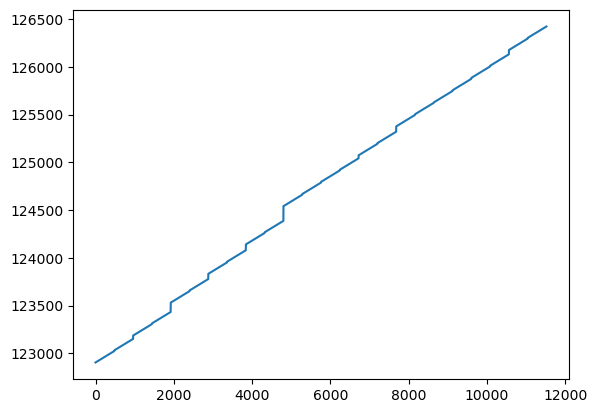

In [362]:
## SEEMS TO WORK OK! nice

plt.plot(df_beh['timing_meg'])

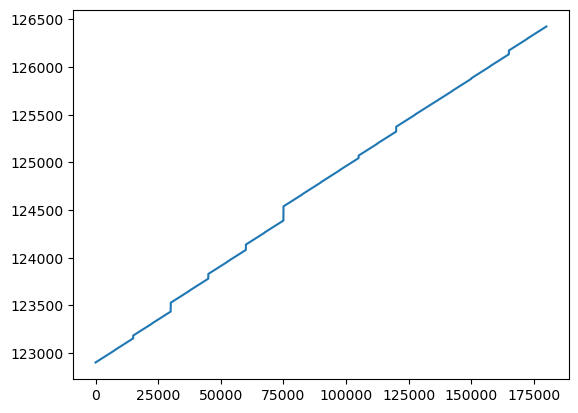

In [374]:
plt.plot(df['TIMESTAMP'])

In [26]:
# main loading
def data_load(pp,data_dir, stim_dir):
    """load mainpred mat file and stimuli matfile"""
    mat = scipy.io.loadmat(join(data_dir,
                                f'{pp}-mainpred.mat'))
    stimuli = scipy.io.loadmat(join(stim_dir, 
                                    f'{pp}_main_stims.mat'))
    return(mat, stimuli)


def stims_load(mat, stimuli):
    """using information from stimuli and pulse timing create dataframe 
    with frequency information, pulse location etc.
    note: 'volume_rel' & 'vol_abs' are the volume where this stimuli was measured
    'closest_volume_rel' & 'closest_volume_abs' are the volume which is the closest in time
    (half tr shift) - since a tr should capture information within that tr"""

    # set arrays
    freqz   = np.array([])
    timingz  = np.array([])
    runz     = np.array([])
    blockz   = np.array([])
    segmenz  = np.array([])
    centaz   = np.array([])
    centbz   = np.array([])
    probaz   = np.array([])
    probbz   = np.array([])

    for blk in np.arange(1, mat['timingz'][1].max()+1):
        # get blockidx
        idxblock = np.where(mat['timingz'][1] == blk) # where block is 1

        #get frequency presentation data for block
        frequencies = stimuli['pres_freq'][int(blk)-1, :]

        # other values
        tps = np.sum(mat['timingz'][3, idxblock] == 1) # get trials per secion

        #get timings back from mat file, substract begin time
        timings = mat['timingz'][4, idxblock]
        matidx = np.where(mat['segmentz'][1] == blk)

        # append to arrays
        freqz = np.append(freqz, frequencies)
        timingz = np.append(timingz, timings)
        runz = np.append(runz, np.repeat(mat['segmentz'][0][matidx], tps))
        blockz = np.append(blockz, np.repeat(mat['segmentz'][1][matidx], tps))
        segmenz = np.append(segmenz, np.repeat(mat['segmentz'][2][matidx], tps))
        centaz = np.append(centaz, 2**np.repeat(mat['segmentz'][7][matidx], tps))   # cent freq a
        centbz = np.append(centbz, 2**np.repeat(mat['segmentz'][8][matidx], tps))  # cent freq b
        probaz = np.append(probaz, np.repeat(mat['segmentz'][5][matidx], tps))
        probbz = np.append(probbz, np.repeat(mat['segmentz'][6][matidx], tps))

    # oct variant 
    freqz_oct = np.log2(freqz)
    centaz_oct = np.log2(centaz)
    centbz_oct = np.log2(centbz)

    # put data into a dictionary and subsequentially in a dataframe
    stim_df_dict = {'frequencies': freqz,
                    'frequencies_oct': freqz_oct,
                    'timing': timingz,
                    'run': runz,
                    'block': blockz,
                    'segment': segmenz,
                    'center_freq_a': centaz,
                    'center_freq_b': centbz,
                    'center_freq_a_oct': centaz_oct,
                    'center_freq_b_oct': centbz_oct,
                    'probability_a': probaz,
                    'probability_b': probbz
                   }

    stim_df = pd.DataFrame(stim_df_dict)
    return(stim_df)

def sync_timing(df, sync_val, timingname='timing', new_timingname='timing_meg'):
    """use syncing value to get timings from stimpc domain into the MEG clock domain
    input df and sync value, returns adjusted dataframe"""

    # create new column in old dataframe
    df[new_timingname] = df[timingname] + sync_val
    # and return
    return(df)


# def pulses_load(pp, input_dir, nr_runs):
#     """load pulses of each run into a pandas dataframe"""
    
#     # set empty array to concatenate pulse fetched data
#     allpulsez = 0

#     # loop over runs and parse data
#     for currun in np.arange(1,nr_runs+1):
#         pulsez = scipy.io.loadmat(join(input_dir,
#                                        f'{pp}/_{pp}-r{currun}-pulses.mat'))['pulsez']
#         pulsez = np.vstack([np.repeat(currun, pulsez.shape[1]), pulsez])
#         try:
#             allpulsez = np.concatenate((allpulsez,pulsez),axis=1)
#         except:
#             allpulsez = pulsez

#     # put in dataframe
#     pulsez_df = pd.DataFrame(np.transpose(allpulsez), columns=['run', 'block', 'timing'])
#     return(pulsez_df)

# def volumes_load(pulsez_df, tr, volumes, nr_runs=False):
#     """given pulses dataframe, tr and volumes
#     create dataframe in volume space (add no pulses gaps)"""
    
#     # nr of runs calculations
#     if not nr_runs: nr_runs = int(pulsez_df['run'].max())

#     # precreate dicts
#     tm = {}
#     onoff = {}
#     block = {}

#     # loop over all the runs
#     for currun in np.arange(1, nr_runs+1):
#         tm[currun], onoff[currun] = find_onoff(pulsez_df, currun, tr=tr, volumes=volumes)
#         block[currun] = find_block(pulsez_df, 1, tr=tr, volumes=volumes)
        
#     # append to one full array
#     tmz = np.array([])
#     onoffz = np.array([])
#     runz = np.array([])
#     blockz = np.array([])

#     # loop over runs and fill
#     for currun in tm.keys():
#         tmz = np.append(tmz, tm[currun])
#         onoffz = np.append(onoffz, onoff[currun]) 
#         runz = np.append(runz, np.array([currun] * len(tm[currun])))
#         blockz = np.append(blockz, block[currun]) 

#     # put everything in a pandas dataframe
#     df_inf = {'timing':tmz, 'run':runz, 'block':blockz, 'on-times':onoffz}
#     volumes_df = pd.DataFrame(df_inf)
    
#     return(volumes_df)

# def find_onoff(pulsez_df, currun, tr=1.8, volumes=245):
#     """for volumes and tr, calculate the on off timings"""
#     # load important info
#     ab_t0 = pulsez_df['timing'][pulsez_df['run']==currun].iloc[0]  # this is for run 1
#     ab_end = pulsez_df['timing'][pulsez_df['run']==currun].iloc[-1]  # this is for run 1
    
#     # set range
#     pulserangerun = np.linspace(ab_t0, ab_end, num=volumes, retstep=False)
#     ontimes = pulsez_df['timing'][pulsez_df['run']==currun].to_numpy()
    
#     # get off times
#     offtimes = np.abs(pulserangerun[:,None]-ontimes).argmin(0) # get on times
#     onoff = np.ones(volumes)
#     onoff[offtimes] = 0 # set off times to 0
#     return(pulserangerun, onoff)

# def find_block(pulsez_df, currun, tr=1.8, volumes=245):
#     # load important info
#     ab_t0 = pulsez_df['timing'][pulsez_df['run']==currun].iloc[0]  # this is for run 1
#     ab_end = pulsez_df['timing'][pulsez_df['run']==currun].iloc[-1]  # this is for run 1
#     blocks = pulsez_df['block'][pulsez_df['run']==currun].to_numpy()
    
#     # set range
#     pulserangerun = np.linspace(ab_t0, ab_end, num=volumes, retstep=False)
#     ontimes = pulsez_df['timing'][pulsez_df['run']==currun].to_numpy()

#     # get off times
#     offtimes = np.abs(pulserangerun[:,None]-ontimes).argmin(0) # get on times
#     allblocks = np.empty(volumes)
#     allblocks[:] = np.nan
    
#     allblocks[offtimes] = blocks # set off times to 0
#     allblocks = ffill(allblocks) # forward fill the array
#     return(allblocks)

# def closest_vol(volumes_df, timingz, runz):
#     a = volumes_df['timing'].to_numpy()
#     b = timingz
    
#     # get volume
#     seq_vol = np.abs(a[:,None]-b).argmin(0)
#     rel_vol = seq_vol - (runz-1)*float(len(volumes_df[volumes_df['run'] == 1]))
#     return(seq_vol, rel_vol.astype(int))

# def closest_vol_floor(volumes_df, timingz, runz):
#     a = volumes_df['timing'].to_numpy()
#     b = timingz

#     # get volume
#     dist = (a[:,None]-b) # get the distance
#     dist[dist < 0.05] = 999 # get rid of pos distancane (- some window)
#     seq_vol = np.abs(dist).argmin(0)
#     rel_vol = seq_vol - (runz-1)*float(len(volumes_df[volumes_df['run'] == 1]))
#     return(seq_vol, rel_vol.astype(int))

# def closest_vol_timing(volumes_df, timingz, runz):
#     a = volumes_df['timing'].to_numpy()
#     b = timingz

#     # get volume
#     seq_vol = np.abs(a[:,None]-b).argmin(0)
#     rel_vol = seq_vol - (runz-1)*float(len(volumes_df[volumes_df['run'] == 1]))
#     return(seq_vol, rel_vol)

def ffill(arr, axis=0):
    idx_shape = tuple([slice(None)] + [np.newaxis] * (len(arr.shape) - axis - 1))
    idx = np.where(~np.isnan(arr), np.arange(arr.shape[axis])[idx_shape], 0)
    np.maximum.accumulate(idx, axis=axis, out=idx)
    slc = [np.arange(k)[tuple([slice(None) if dim==i else np.newaxis
        for dim in range(len(arr.shape))])]
        for i, k in enumerate(arr.shape)]
    slc[axis] = idx
    return arr[tuple(slc)]

def flatten(d):
    return(pd.json_normalize(d, sep='_').to_dict(orient='records')[0])

def gauss(x, x0, sigma):
    return np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [ ]:
## series of functions to load matlab data and parse them into usebable formats

import scipy.io
import pandas as pd
import numpy as np
import re

import os
from os.path import join

# import matlab.engine

import matplotlib.pyplot as plt

# import Adaptation.longtrace_adaptation as longtrace_adaptation
# import Adaptation.longtrace_adaptation_timedomain as longtrace_adaptation_timedomain

# import vtc

# load current directory
dir_path = os.path.dirname(os.path.realpath(__file__))

# vtc / y data loading 

# def load_vtc_chunk_runs(vtc_fns, msk_indeces):
#     """load decired chunk over a list of runs
#     input: vtc_fn (list of strings): list of full path vtc filenames
#            msk_indeces (3x np.array): np.where style indeces of what voxels"""
    
#     # load only header information
#     head, _ = vtc.read_vtc_msk(vtc_fns[0], tuple((np.array([0]),
#                                                   np.array([0]),
#                                                   np.array([0]))))

#     # get expected vtc dim
#     vtcdim = vtc.get_vtc_dims(head)
    
#     # predefine full image over runs
#     # y = np.zeros((msk[0].shape[0], vtcdim[-1], nr_runs))
#     y = np.zeros((msk_indeces[0].shape[0], vtcdim[-1], len(vtc_fns)))
#     run_nr = np.zeros((vtcdim[-1], len(vtc_fns)))
    
#     # loop over all filenames
#     for run in range(len(vtc_fns)):

#         # set vtc path
#         fullpath = vtc_fns[run]
        
#         # mask the vtc
#         _, y[:,:,run] = vtc.read_vtc_msk(fullpath, msk_indeces)
#         run_nr[:, run] = run + 1
        
#     # reshape into single dim
#     run_nr = run_nr.reshape((-1),order='F')
#     y = y.reshape((y.shape[0], -1), order='F')
#     return(y, run_nr)
    
    
# def reconstruct_vtc(img, msk_indeces, vtc_for_header=None):
#     """reconstruct image in zeros array, takingen [voxels x time] and indeces 
#     as input.
#     input: img (array): input array of [voxels, timepoints]
#            msk_indeces (3x np.array): np.where style indeces of what voxels
#                         should have same length as img
#            vtc_for_header (string) : vtc filename to use for header - needed for 
#                         dimensions. when missing take max of msk_indeces instead.
#                         (this will cause one sided padding).
#     return: reconstructed image in format of vtc"""
    
#     # check if we can load a vtc from header
#     #  else, take from mask (will be padded)
#     if vtc_for_header:
#         # load header info only (no img data)
#         head, _ = vtc.read_vtc_msk(vtc_for_header, tuple((np.array([0]),
#                                                     np.array([0]),
#                                                     np.array([0]))))
#         # get vtc dims
#         vtcdim = vtc.get_vtc_dims(head)
#     else:
#         # set dimensions if no vtc header was given
#         vtcdim = [np.max(c)+1 for c in msk_indeces] + [img.shape[-1]]
        
#     # preprecreat a empty image with the dimension
#     #  of the full vtc - for plotting purpuses
#     rec_img = np.zeros(vtcdim)

#     # fill in chuck in reconstructed image
#     rec_img[msk_indeces] = img
#     return(rec_img)

## main functions

## post processing
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# def find_padding(tr, ntrials, tlen):
#     padding = 0
#     notdiv = int(ntrials*tlen*10) % int(tr*10)
#     while notdiv != 0:
#         padding += 1
#         newlen = ntrials + padding
#         # check if modulated by 10 is whole number 
#         if (newlen*tlen*10).is_integer():
#             notdiv = int(newlen*tlen*10) % int(tr*10)
#         if padding > 100000: 
#             raise Exception("Sorry, padding not possible") 
#     return(padding)

# def get_reg_collumns(df, convolved=False,
#                      pred_reg = 'pred_prob_[_0-9.]+',
#                      acti_reg = 'raw_acti_[_0-9.]+',
#                      adpt_reg = 'raw_adapt_[_0-9.]+',
#                      acadpt_reg = 'adapt_activ_[_0-9.]+',
#                      surp_reg = 'surprisal',
#                      onoff_reg = 'onoff'):
#     """get all regressors collumn names in one list
#     optionally sellect convolved variants"""
#     # get one list with all
#     columns_reg = []
#     # add convolved suffix
#     if convolved: suffix='convolved$'
#     else: suffix='$'
#     # loop over all, adding suffix
#     for reg in ['{}{}'.format(i, suffix) for i in [pred_reg, acti_reg, adpt_reg, acadpt_reg, surp_reg, onoff_reg]]:
#         columns_reg += df.filter(regex=reg).columns.tolist()
#     return(columns_reg)

# def get_tw_collumns(df, tp, tw, convolved=False,
#                      pred_reg = 'pred_prob_',
#                      acti_reg = 'raw_acti_',
#                      adpt_reg = 'raw_adapt_',
#                      acadpt_reg = 'adapt_activ_',
#                      surp_reg = 'surprisal',
#                      exta_reg = 'onoff'):
#     """get all by tuning prefference (tp) and tuning width (tw)"""
#     # get one list with all
#     columns_reg = []
#     # add convolved suffix
#     if convolved: suffix='_convolved$'
#     else: suffix='$'
      
#     # adjust column names
#     pred_reg = '{}{:.3f}{}'.format(pred_reg, tp, suffix)
#     acti_reg = '{}{:.3f}_{:.3f}{}'.format(acti_reg, tp, tw, suffix)
#     adpt_reg = '{}{:.3f}_{:.3f}{}'.format(adpt_reg, tp, tw, suffix)
#     acadpt_reg = '{}{:.3f}_{:.3f}{}'.format(acadpt_reg, tp, tw, suffix)
#     surp_reg = '{}{}'.format(surp_reg, suffix)
#     exta_reg = '{}{}'.format(exta_reg, suffix)
#     # loop over all
#     for reg in [pred_reg, acti_reg, adpt_reg, acadpt_reg, surp_reg, exta_reg]:
#         columns_reg += df.filter(regex=reg).columns.tolist()
#     return(columns_reg)

# def stims_add_temporal_pad(df, volumes_df, trialleng=None, trleng=None):
#     """take dataframe, loop over blocks, and add inbetween timing values,
#     while this is not 100% precise (and it doesnt have to be), this step is crucial
#     in order for the hrf convolvement to work as intended
#     input: df (stimulus dataframe), trailleng (length of single trial - if None, get from first diff),
#     and append_end (how manny seconds to add after last block)"""

#     # if not specified calculate trialleng
#     if not trialleng: trialleng = df['timing'].diff()[1]
#     if not trleng: trleng = volumes_df['timing'].diff()[1]
        
#     # get column regressor names
#     columns_reg = get_reg_collumns(df)
    
#     temp_dfs = {}
#     # loop over runs
#     for blk in df['block'].unique():
        
#         # get last and first idx value of this block
#         blk_endidx = df[df['block'] == blk].index[-1]
#         blk_stridx = df[df['block'] == blk].index[0]
#         currun = df['run'].iloc[blk_endidx]
        
#         # if not last volume of block, simply count to next stimuli
#         if currun == df['run'].shift(-1).iloc[blk_endidx]:
#             nd_timing = df['timing'].iloc[blk_endidx+1]-0.1,   # ensure non duplicated
#         # if last block of a run, count to last volume in run
#         else:
#             nd_timing = volumes_df[volumes_df['run'] == currun]['timing'].to_numpy()[-1]

#         # create intermediate timing values
#         blk_append = np.arange(df['timing'].iloc[blk_endidx]+trialleng, 
#                                nd_timing,
#                                trialleng)
            
#         # if first block of run also pad from start of block  # NOW JUST FIRST BLOCK, MAKE FIRST BLOCK RUN
#         if currun != df['run'].shift(1).iloc[blk_stridx]:
#             run_starttime = volumes_df[volumes_df['run'] == currun]['timing'].to_numpy()[0] - trleng
#             blk_append = np.append(np.arange(run_starttime,  # ensure first volume
#                                              df['timing'].iloc[blk_stridx]-0.1,   # ensure non duplicated
#                                              trialleng),
#                                    blk_append)

#         # allocate everything with zeros (important for convolution)
#         temp_dfs[blk] = pd.DataFrame(0, 
#                                      index=np.arange(len(blk_append)),
#                                      columns=df.columns)
    
#         # set non regressors to nan or to corresponding
#         temp_dfs[blk][list(set(df.columns) - set(columns_reg))] = np.nan
#         temp_dfs[blk]['timing'] = blk_append
#         temp_dfs[blk]['run'] = currun
#         temp_dfs[blk]['block'] = blk
    
#     # combine dataframes
#     df_list = [0] + list(df['block'].unique())
#     temp_dfs[0] = df
#     df = pd.concat([temp_dfs[k] for k in df_list], ignore_index=True)
#     df = df.sort_values(by=['timing'], ignore_index=True)
    
#     # finally recalculate what volume this timing fall in (both floor and closest)
#     timings = df['timing'].to_numpy()
#     run = df['run'].to_numpy()
#     vol_absz, vol_relz = closest_vol(volumes_df, timings, run)
#     vol_abs_flrz, vol_rel_flrz = closest_vol_floor(volumes_df, timings, run)
    
#     # apply volume timing to dataframe
#     df['closest_volume_rel'] = vol_relz
#     df['closest_volume_abs'] = vol_absz
#     df['volume_rel'] = vol_rel_flrz
#     df['volume_abs'] = vol_abs_flrz
    
#     # add on off column
#     df['onoff'] = df['frequencies'].notna().astype(float)
    
#     return(df)

# def stims_convolve_hrf(df, hrf):
#     """input pandas dataframe, and convolve with an hrf array (must have same x-dim)
#     return adjusted dataframe with suffix _convolved"""
    
#     # sellect columns to convolve
#     columns_reg = get_reg_collumns(df)
#     input_array = df[columns_reg].to_numpy()

#     # do actual convolvement, many with one
#     convolved = np.apply_along_axis(lambda m: np.convolve(m, hrf, mode='full'), 
#                                     axis=0, 
#                                     arr=df[columns_reg].to_numpy())[:input_array.shape[0],:]

#     # put in dataframe and join into input dataframe
#     convolved_df = pd.DataFrame(convolved, columns=columns_reg)
#     df = df.join(convolved_df, rsuffix='_convolved')
#     return(df)

# def stims_to_tr(stim_df, volumes_df, downsample_unconv=False):
#     """from dataframe in stimulus domain, create tr dataframe
#     if downsample_unconv is True, also downsample (using scipy) unconvolved columns"""
    
#     # to get dataframe in tr space, simply 
#     tr_df = stim_df.groupby(['volume_abs']).nth(3)

#     # also downsameple in a waveform manner, to preserve more data
#     all_reg = get_reg_collumns(stim_df, convolved = True)
#     if downsample_unconv: all_reg += get_reg_collumns(stim_df, convolved = False)
#     downsampled_reg = pd.DataFrame(scipy.signal.resample(stim_df[all_reg], len(volumes_df)),
#                                    columns = all_reg)
    
#     # make, setting new values to original, and from groupby to '_sum'
#     tr_df = tr_df.join(downsampled_reg, lsuffix='_mid')
#     return(tr_df)


# def con_hrf_stimdomain(hrf, stim_df, plotres=False):
#     """given a mat function and triallength obtained from stim_df, 
#     get hrf in correct domain for convolution"""

#     # input hrf
#     con_hrf = [hrf['xdata'][0,:], hrf['ydata'][0,:]]

#     # hrf and stim lengts
#     trialleng = stim_df['timing'].diff()[1]
#     con_hrf_vollen = np.diff(con_hrf[0])[0]

#     # interpolate
#     xnew = np.arange(np.min(con_hrf[0]), np.max(con_hrf[0]), trialleng)
#     f = scipy.interpolate.interp1d(con_hrf[0], con_hrf[1], kind='cubic')
#     newhrf = normalize(f(xnew)) # normalized (top scaled to 1)
    
#     # plot results if wanted
#     if plotres:
#         plt.plot(xnew, newhrf)
#         plt.plot(con_hrf[0], normalize(con_hrf[1]))
#         print(f'new step size {np.diff(xnew)[0]}')
#     return(newhrf)

#drex
def stims_export_mat(pp, input_dir, stim_df, pref_range):
    """export dataframe into mat file"""
    stim_mat = {}

    # get stimuli data
    stim_mat['stims'] = stim_df.to_dict('list')

    # aditionally get range data
    stim_mat['oct_range'] = list(pref_range)
    stim_mat['freq_range'] = list(2 ** pref_range)

    scipy.io.savemat(join(input_dir, '{}/{}_stimdf.mat'.format(pp, pp)), stim_mat)
    return


def run_drex(pp, input_dir):
    """run drex model in matlab, save output as matfile"""
    eng = matlab.engine.start_matlab()

    # add prediction, drex path
    s = eng.genpath(join(dir_path, 'Prediction', 'DREX'))
    eng.addpath(s, nargout=0)

    # run drex wrapper
    eng.rundrex_stims(pp, input_dir, nargout=0)
    return


def stims_add_drex(pp, input_dir, stim_df):
    """load drex output mat, and append to dataframe"""
    # load drex mat
    mat = scipy.io.loadmat(join(input_dir,'{}/{}_drexdf.mat'.format(pp, pp)))

    # loop over frequencies
    collumn_names = ['pred_prob_{:.3f}'.format(frq) for frq in mat['s_range'][0]]
    temp_df = pd.DataFrame(columns=collumn_names)
    for frq in range(len(mat['s_range'][0])):
        cur_frq = mat['s_range'][0, frq]
        temp_df['pred_prob_{:.3f}'.format(cur_frq)] = mat['prob_array'][frq]

    # append surprisal and predictive probabilities
    stim_df['surprisal'] = mat['surp_array'][0]
    stim_df = pd.concat([stim_df, temp_df], axis=1)
    return(stim_df)

# adaptation
def run_adaptation(stim_df, pref_range, sharp_range, y_decay):
    """wrapper functions to run adaptation model and return long matrixes of [pref*tw, stimuli]"""
    
    # calculate raw activation
    stims = stim_df['frequencies_oct'].to_numpy()
    activations = longtrace_adaptation.md_gaussian_activations(pref_range, sharp_range, stims)
    adaptations = np.zeros([len(pref_range)*len(sharp_range), len(stims)])
    n_back_adaptations = np.zeros([len(pref_range)*len(sharp_range), len(stims), len(y_decay)])

    for blk in stim_df['block'].unique():
        # get all stimuli within this block & get start and end idx of block
        stims = stim_df['frequencies_oct'][stim_df['block'] == blk].to_numpy()
        st_idx = stim_df.index[stim_df['block'] == blk][0]
        nd_idx = stim_df.index[stim_df['block'] == blk][-1] + 1

        # calculate adaptation for current block
        adaptations[:, st_idx:nd_idx], n_back_adaptations[:, st_idx:nd_idx, :] = longtrace_adaptation.md_stim_adaptation(stims, 
                                                                                                    y_decay, 
                                                                                                    pref_range, 
                                                                                                    sharp_range)

    # calculate adaptation weighted activations
    adapted_activations = np.multiply(adaptations, activations)

    return(activations, adaptations, adapted_activations, n_back_adaptations)


def stims_add_adaptation(stim_df, pref_range, sharp_range, activations, adaptations, adapted_activations):
    """given a adaptation, activation and adaptated activation matrix, update the dataframe"""
    # create a list of all indexes
    all_idxs = np.arange(len(pref_range) * len(sharp_range))

    # get list of 
    tunprefs, tunsharps = longtrace_adaptation.md_get_tuning(all_idxs, pref_range, sharp_range)

    # get dictionaries by naming
    acti_names = {'raw_acti_{:.3f}_{:.3f}'.format(tunprefs[idx], tunsharps[idx]): 
                  activations[idx, :] for idx in all_idxs}
    adapt_names = {'raw_adapt_{:.3f}_{:.3f}'.format(tunprefs[idx], tunsharps[idx]): 
                   adaptations[idx, :] for idx in all_idxs}
    adapt_acti_names = {'adapt_activ_{:.3f}_{:.3f}'.format(tunprefs[idx], tunsharps[idx]): 
                        adapted_activations[idx, :] for idx in all_idxs}

    # combine dictionaries
    acti_names.update(adapt_names)
    acti_names.update(adapt_acti_names)
    
    # append adapation and activation to pd dataframe
    stim_df = pd.concat([stim_df, pd.DataFrame(acti_names)], axis=1)
    return(stim_df)

# main loading
def data_load(pp,input_dir):
    """load mainpred mat file and stimuli matfile"""
    mat = scipy.io.loadmat(join(input_dir,
                                f'{pp}-mainpred.mat'))
    stimuli = scipy.io.loadmat(join(input_dir, 
                                    f'{pp}_main_stims.mat'))
    return(mat, stimuli)


def stims_load(puls_df, volumes_df, mat, stimuli):
    """using information from stimuli and pulse timing create dataframe 
    with frequency information, pulse location etc.
    note: 'volume_rel' & 'vol_abs' are the volume where this stimuli was measured
    'closest_volume_rel' & 'closest_volume_abs' are the volume which is the closest in time
    (half tr shift) - since a tr should capture information within that tr"""

    # set arrays
    freqz   = np.array([])
    timingz  = np.array([])
    runz     = np.array([])
    blockz   = np.array([])
    segmenz  = np.array([])
    centaz   = np.array([])
    centbz   = np.array([])
    probaz   = np.array([])
    probbz   = np.array([])

    for blk in np.arange(1, puls_df['block'].max()+1):
        # get blockidx
        idxblock = np.where(mat['timingz'][1] == blk) # where block is 1

        #get frequency presentation data for block
        frequencies = stimuli['pres_freq'][int(blk)-1, :]

        # other values
        tps = np.sum(mat['timingz'][3, idxblock] == 1) # get trials per secion

        #get timings back from mat file, substract begin time
        timings = mat['timingz'][4, idxblock]
        matidx = np.where(mat['segmentz'][1] == blk)

        # append to arrays
        freqz = np.append(freqz, frequencies)
        timingz = np.append(timingz, timings)
        runz = np.append(runz, np.repeat(mat['segmentz'][0][matidx], tps))
        blockz = np.append(blockz, np.repeat(mat['segmentz'][1][matidx], tps))
        segmenz = np.append(segmenz, np.repeat(mat['segmentz'][2][matidx], tps))
        centaz = np.append(centaz, 2**np.repeat(mat['segmentz'][7][matidx], tps))   # cent freq a
        centbz = np.append(centbz, 2**np.repeat(mat['segmentz'][8][matidx], tps))  # cent freq b
        probaz = np.append(probaz, np.repeat(mat['segmentz'][5][matidx], tps))
        probbz = np.append(probbz, np.repeat(mat['segmentz'][6][matidx], tps))

    # oct variant 
    freqz_oct = np.log2(freqz)
    centaz_oct = np.log2(centaz)
    centbz_oct = np.log2(centbz)

    # get closest pulse
    vol_absz, vol_relz = closest_vol(volumes_df, timingz, runz)
    vol_abs_flrz, vol_rel_flrz = closest_vol_floor(volumes_df, timingz, runz)

    # put data into a dictionary and subsequentially in a dataframe
    stim_df_dict = {'frequencies': freqz,
                    'frequencies_oct': freqz_oct,
                    'timing': timingz,
                    'closest_volume_rel' : vol_relz,
                    'closest_volume_abs' : vol_absz,
                    'volume_rel' : vol_rel_flrz,
                    'volume_abs' : vol_abs_flrz,
                    'run': runz,
                    'block': blockz,
                    'segment': segmenz,
                    'center_freq_a': centaz,
                    'center_freq_b': centbz,
                    'center_freq_a_oct': centaz_oct,
                    'center_freq_b_oct': centbz_oct,
                    'probability_a': probaz,
                    'probability_b': probbz
                   }

    stim_df = pd.DataFrame(stim_df_dict)
    return(stim_df)


def pulses_load(pp, input_dir, nr_runs):
    """load pulses of each run into a pandas dataframe"""
    
    # set empty array to concatenate pulse fetched data
    allpulsez = 0

    # loop over runs and parse data
    for currun in np.arange(1,nr_runs+1):
        pulsez = scipy.io.loadmat(join(input_dir,
                                       f'{pp}/_{pp}-r{currun}-pulses.mat'))['pulsez']
        pulsez = np.vstack([np.repeat(currun, pulsez.shape[1]), pulsez])
        try:
            allpulsez = np.concatenate((allpulsez,pulsez),axis=1)
        except:
            allpulsez = pulsez

    # put in dataframe
    pulsez_df = pd.DataFrame(np.transpose(allpulsez), columns=['run', 'block', 'timing'])
    return(pulsez_df)

def volumes_load(pulsez_df, tr, volumes, nr_runs=False):
    """given pulses dataframe, tr and volumes
    create dataframe in volume space (add no pulses gaps)"""
    
    # nr of runs calculations
    if not nr_runs: nr_runs = int(pulsez_df['run'].max())

    # precreate dicts
    tm = {}
    onoff = {}
    block = {}

    # loop over all the runs
    for currun in np.arange(1, nr_runs+1):
        tm[currun], onoff[currun] = find_onoff(pulsez_df, currun, tr=tr, volumes=volumes)
        block[currun] = find_block(pulsez_df, 1, tr=tr, volumes=volumes)
        
    # append to one full array
    tmz = np.array([])
    onoffz = np.array([])
    runz = np.array([])
    blockz = np.array([])

    # loop over runs and fill
    for currun in tm.keys():
        tmz = np.append(tmz, tm[currun])
        onoffz = np.append(onoffz, onoff[currun]) 
        runz = np.append(runz, np.array([currun] * len(tm[currun])))
        blockz = np.append(blockz, block[currun]) 

    # put everything in a pandas dataframe
    df_inf = {'timing':tmz, 'run':runz, 'block':blockz, 'on-times':onoffz}
    volumes_df = pd.DataFrame(df_inf)
    
    return(volumes_df)

def find_onoff(pulsez_df, currun, tr=1.8, volumes=245):
    """for volumes and tr, calculate the on off timings"""
    # load important info
    ab_t0 = pulsez_df['timing'][pulsez_df['run']==currun].iloc[0]  # this is for run 1
    ab_end = pulsez_df['timing'][pulsez_df['run']==currun].iloc[-1]  # this is for run 1
    
    # set range
    pulserangerun = np.linspace(ab_t0, ab_end, num=volumes, retstep=False)
    ontimes = pulsez_df['timing'][pulsez_df['run']==currun].to_numpy()
    
    # get off times
    offtimes = np.abs(pulserangerun[:,None]-ontimes).argmin(0) # get on times
    onoff = np.ones(volumes)
    onoff[offtimes] = 0 # set off times to 0
    return(pulserangerun, onoff)

def find_block(pulsez_df, currun, tr=1.8, volumes=245):
    # load important info
    ab_t0 = pulsez_df['timing'][pulsez_df['run']==currun].iloc[0]  # this is for run 1
    ab_end = pulsez_df['timing'][pulsez_df['run']==currun].iloc[-1]  # this is for run 1
    blocks = pulsez_df['block'][pulsez_df['run']==currun].to_numpy()
    
    # set range
    pulserangerun = np.linspace(ab_t0, ab_end, num=volumes, retstep=False)
    ontimes = pulsez_df['timing'][pulsez_df['run']==currun].to_numpy()

    # get off times
    offtimes = np.abs(pulserangerun[:,None]-ontimes).argmin(0) # get on times
    allblocks = np.empty(volumes)
    allblocks[:] = np.nan
    
    allblocks[offtimes] = blocks # set off times to 0
    allblocks = ffill(allblocks) # forward fill the array
    return(allblocks)

def closest_vol(volumes_df, timingz, runz):
    a = volumes_df['timing'].to_numpy()
    b = timingz
    
    # get volume
    seq_vol = np.abs(a[:,None]-b).argmin(0)
    rel_vol = seq_vol - (runz-1)*float(len(volumes_df[volumes_df['run'] == 1]))
    return(seq_vol, rel_vol.astype(int))

def closest_vol_floor(volumes_df, timingz, runz):
    a = volumes_df['timing'].to_numpy()
    b = timingz

    # get volume
    dist = (a[:,None]-b) # get the distance
    dist[dist < 0.05] = 999 # get rid of pos distancane (- some window)
    seq_vol = np.abs(dist).argmin(0)
    rel_vol = seq_vol - (runz-1)*float(len(volumes_df[volumes_df['run'] == 1]))
    return(seq_vol, rel_vol.astype(int))

def closest_vol_timing(volumes_df, timingz, runz):
    a = volumes_df['timing'].to_numpy()
    b = timingz

    # get volume
    seq_vol = np.abs(a[:,None]-b).argmin(0)
    rel_vol = seq_vol - (runz-1)*float(len(volumes_df[volumes_df['run'] == 1]))
    return(seq_vol, rel_vol)

def ffill(arr, axis=0):
    idx_shape = tuple([slice(None)] + [np.newaxis] * (len(arr.shape) - axis - 1))
    idx = np.where(~np.isnan(arr), np.arange(arr.shape[axis])[idx_shape], 0)
    np.maximum.accumulate(idx, axis=axis, out=idx)
    slc = [np.arange(k)[tuple([slice(None) if dim==i else np.newaxis
        for dim in range(len(arr.shape))])]
        for i, k in enumerate(arr.shape)]
    slc[axis] = idx
    return arr[tuple(slc)]

def flatten(d):
    return(pd.json_normalize(d, sep='_').to_dict(orient='records')[0])

def gauss(x, x0, sigma):
    return np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [ ]:
df[labels]

In [19]:
time_dict

{(0,): array([[122901.34833333],
        [122901.365     ],
        [122901.38166667],
        ...,
        [123026.24833333],
        [123026.265     ],
        [123026.28166667]]),
 (1,): array([[123028.465     ],
        [123028.48166667],
        [123028.49833333],
        ...,
        [123153.365     ],
        [123153.38166667],
        [123153.39833333]]),
 (2,): array([[123183.14833333],
        [123183.165     ],
        [123183.18166667],
        ...,
        [123308.04833333],
        [123308.065     ],
        [123308.08166667]]),
 (3,): array([[123310.24833333],
        [123310.265     ],
        [123310.28166667],
        ...,
        [123435.14833333],
        [123435.165     ],
        [123435.18166667]]),
 (4,): array([[123528.015     ],
        [123528.03166667],
        [123528.04833333],
        ...,
        [123652.915     ],
        [123652.93166667],
        [123652.94833333]]),
 (5,): array([[123655.115     ],
        [123655.13166667],
        [123655.14833333]

In [219]:
file_ref_shape

24

In [208]:
abc = {}
abc[cell] = np.array(file[file_refferences[cell]])

In [214]:
import numpy as np

def simplify_shape(shape_tuple):
    dimensions = tuple(dim for dim in shape_tuple if dim != 1)
    if len(dimensions) == 1:
        return dimensions[0]
    return dimensions

# Example shape
file_references_shape = (24, 1, 10)

simplified_shape = simplify_shape(file_references_shape)
print(simplified_shape)  # Output: 24

(24, 10)


In [207]:
np.array(file[file_refferences[cell]])

array([[-1.00725953e-13, -4.88925288e-14, -2.60872845e-14, ...,
         6.43516696e-13,  1.09810425e-12,  4.82412776e-13],
       [-1.44936871e-13, -7.67285201e-14, -2.08620416e-14, ...,
         4.91475440e-13,  1.77861736e-12,  2.32027404e-13],
       [-1.41780507e-13, -1.13249334e-13, -7.55760355e-14, ...,
         1.11204172e-13,  1.61656141e-12, -4.84102514e-14],
       ...,
       [-3.05462491e-14,  5.59567426e-14,  6.57604452e-14, ...,
         4.16086566e-14,  5.34901976e-13,  5.72719231e-13],
       [-8.35461941e-14,  1.10155319e-14,  5.67659095e-14, ...,
         3.59924719e-13,  6.85905737e-13,  8.11626876e-13],
       [ 1.90169094e-15,  1.39218333e-14,  3.89529997e-14, ...,
         2.14842292e-13,  4.05529843e-13,  4.09433264e-13]])

In [171]:
a = navigate_nested_dict(file, key_list)
np.array(file[a[0, 0]])


array([[-9.59823371e-14, -1.25213376e-13, -2.03982080e-13, ...,
         3.09134357e-13,  2.79004396e-13,  5.42901025e-14],
       [-1.43965002e-13, -2.51394524e-13, -4.60690804e-13, ...,
         4.42280184e-13,  4.14463133e-13, -4.25230160e-14],
       [-1.53069555e-13, -2.62745372e-13, -3.68765884e-13, ...,
         1.84556046e-13,  2.73814474e-13, -1.39827237e-13],
       ...,
       [ 8.95170121e-14,  5.36381064e-14,  6.51693813e-14, ...,
         2.86239929e-14,  1.50352657e-13, -3.86236490e-14],
       [ 1.38682035e-14,  1.47753442e-14,  3.22439205e-14, ...,
         5.60377083e-14,  9.16769756e-14, -9.55285752e-14],
       [ 4.06818367e-14,  3.22977749e-14,  3.46610112e-15, ...,
        -3.97996824e-14,  1.23788055e-13, -9.48804973e-14]])

In [144]:
".".join(key_list)

'data.time'

In [115]:
def navigate_nested_dict(nested_dict, keys_list):
    current_dict = nested_dict
    for key in keys_list:
        if key in current_dict:
            current_dict = current_dict[key]
        else:
            return None  # Key not found
    return current_dict

keys_to_explore = ['data', 'time']
result = navigate_nested_dict(mat_file, keys_to_explore)



In [116]:
result

<HDF5 dataset "time": shape (24, 1), type "|O">

In [45]:
mat_file = h5py.File(join(input_dir, fn), 'r')
mat_file['data'].keys()

<KeysViewHDF5 ['cfg', 'elec', 'fsample', 'grad', 'label', 'time', 'trial', 'trialinfo', 'trigger', 'trigger_label']>

In [107]:
mat_file[mat_file['data']['label'][:][0,5]]


<HDF5 dataset "3": shape (5, 1), type "<u2">

In [106]:
# Open the HDF5 file
with h5py.File(join(input_dir, fn), 'r') as file:
    cell_data = file['data']['label'][()]  # Replace with the actual path to your cell data

# Create an empty list to store the resolved strings
resolved_strings = []

# Resolve the HDF5 object references to strings
for hdf5_ref in cell_data[:, 0]:
    referenced_dataset = file[hdf5_ref]
    string_value = "".join([chr(item) for item in referenced_dataset])  # Convert bytes to string
    resolved_strings.append(string_value)

# Create a pandas DataFrame
df = pd.DataFrame({'labels': resolved_strings})

ValueError: Invalid location identifier (invalid identifier type to function)

In [104]:
dat[:,0][0]

<HDF5 object reference>

In [43]:
sync_mat['MEG_sync']['median']

array([[array([[-56433.86339458]])]], dtype=object)

In [19]:
# settings
mat = scipy.io.loadmat(join(settings_dir, settings_fn))
all_freqs = mat['cfg']['freq_array'][0][0][0,:]

ValueError: no field of name freq_array

In [23]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cfg', 'segmentz', 'timingz', 'None', 'responses', '__function_workspace__'])

In [10]:
join(input_dir,'{}/{}_settings_tonotopy.mat'.format(pp, pp))

'/project/3018063.01/scripts_proc/preproc/sub-010/preproc/main/10/10_settings_tonotopy.mat'

In [7]:
input_dir

'/project/3018063.01/scripts_proc/preproc/sub-010/preproc/main/'

In [3]:
sys.path

['/project/3018063.01/scripts_proc',
 '/project/3018063.01/repos/conda_env/predlis/lib/python38.zip',
 '/project/3018063.01/repos/conda_env/predlis/lib/python3.8',
 '/project/3018063.01/repos/conda_env/predlis/lib/python3.8/lib-dynload',
 '',
 '/project/3018063.01/repos/conda_env/predlis/lib/python3.8/site-packages']

In [5]:
b = b * 10000

MemoryError: 

In [2]:
!pip list

Package              Version
-------------------- ---------
anyio                3.5.0
argon2-cffi          21.3.0
argon2-cffi-bindings 21.2.0
asttokens            2.0.5
attrs                22.1.0
Babel                2.11.0
backcall             0.2.0
beautifulsoup4       4.12.2
bleach               4.1.0
brotlipy             0.7.0
certifi              2023.7.22
cffi                 1.15.0
charset-normalizer   2.0.4
comm                 0.1.2
cryptography         41.0.2
debugpy              1.5.1
decorator            5.1.1
defusedxml           0.7.1
entrypoints          0.4
executing            0.8.3
fastjsonschema       2.16.2
idna                 3.4
importlib-metadata   6.0.0
importlib-resources  5.2.0
ipykernel            6.19.2
ipython              8.12.0
ipython-genutils     0.2.0
ipywidgets           8.0.4
jedi                 0.18.1
Jinja2               3.1.2
json5                0.9.6
jsonschema           4.17.3
jupyter              1.0.0
jupyter-client       7.2.2
jupyter-co